## Importing libraries


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 25 23:26:42 2023

@author: DELL
"""

 #%%
import matplotlib
import pathlib
import os
import mne
import csv
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from mne.io import read_raw_eeglab
from mne_bids import BIDSPath, get_entity_vals, find_matching_paths
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sklearn
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
mne.set_log_level('warning')
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Data will be preloaded.*")
print('done')

done


## Functions

In [2]:
# Function to plot training and validation accuracy/loss
def training_plot(history):
    # Extract training and validation accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
import matplotlib.pyplot as plt

def plot_accuracy(histories):
    plt.figure(figsize=(10, 6))
    
    for history in histories:
        acc = history.history['accuracy']
        #val_acc = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, label='Training acc')
        #plt.plot(epochs, val_acc, label='Validation acc')

    plt.title('Training Acuraccy for each Fold in LOSO')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# histories is a list of history objects, e.g., [history1, history2]
# where each history object contains training and validation accuracy information.
# plot_accuracy(histories)


def calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP):
    # Calculate confusion matrix
    confusion_mtx = confusion_matrix(confusion_true_MLP, confusion_pred_MLP)

    # Define class names
    class_names = ["Control-CN(0)", " Alzhaimer-AD(1)"]

    # Calculate accuracy, sensitivity, specificity, precision, and F1-score
    accuracy = accuracy_score(confusion_true_MLP, confusion_pred_MLP)
    precision = precision_score(confusion_true_MLP, confusion_pred_MLP)
    recall = recall_score(confusion_true_MLP, confusion_pred_MLP)
    f1 = f1_score(confusion_true_MLP, confusion_pred_MLP)
    specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

    # Output metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity (Recall):", recall)
    print("Specificity:", specificity)
    print("F1-score:", f1)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(confusion_true_MLP, confusion_pred_MLP)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
# confusion_true_MLP = ...  # Replace with your true labels
# confusion_pred_MLP = ...  # Replace with your predicted labels
# calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP)





def segmentation(data, labels, segment_duration=20):
    segmented_data, segmented_labels, idx = [], [], -1
    segmented_2D,segmented_2D_labels = [],[]
    overlap_duration = segment_duration * 0.5

    for raw0 in data:
        temp_2D=[]
        temp_2D_labels=[]
        idx = idx + 1
        total_duration = raw0.times[-1]
        num_segments = int(total_duration // (segment_duration - overlap_duration)-1)
        print(raw0)

        for ii in range(num_segments):
            start_time = ii * (segment_duration - overlap_duration)
            end_time = min(start_time + segment_duration, total_duration)  # Ensure end_time doesn't exceed total_duration
            
            segment = raw0.copy().crop(tmin=start_time, tmax=end_time)
            segment_data = segment.get_data()
            
            segmented_data.append(segment)
            temp_2D.append(np.array(segment_data))
            
            segmented_labels.append(labels[idx])
            temp_2D_labels.append(labels[idx])
            
        
        segmented_2D.append(np.array(temp_2D))
        segmented_2D_labels.append(np.array(temp_2D_labels))
        print(end_time)
        

    # Create an array of indices
    num_samples = len(segmented_data)

    return segmented_2D, segmented_2D_labels

def calculate_rbp(epoch, fs):
    # Define frequency bands
    frequency_bands = [(0.5, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    epoch_data=epoch.get_data()
    
    for epoch in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(epoch, fs=fs, nperseg=fs*10, noverlap=fs*1)
        
        total_psd = np.trapz(psd, axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
    
    return np.array(rbp_features)

def shannon_entropy(signal):
    # Calculate the probability distribution of the signal
    unique_values, value_counts = np.unique(signal, return_counts=True)
    probabilities = value_counts /(signal.shape)
    
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

    
import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def calculate_rbp_filter(epoch, fs=500):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    
    for channel in epoch:
        rbp = []
        for band in frequency_bands:
            lowcut, highcut = band
            filtered_data = butter_bandpass_filter(channel, lowcut, highcut, fs)
            band_power = np.sum(filtered_data ** 2) / len(filtered_data)
            rbp.append(band_power)
        rbp_features.append(rbp)
    
    rbp_features = np.array(rbp_features)
    
    return rbp_features


## Data Loading from file

In [3]:
total_subjects = 88 
num_subjects = 10 #How many subjects to include in analysis
random_subjects = True # Set this boolean to True to read subjects randomly

arr_info = np.empty((0, 5))

# Load participant data into 'arr' from a TSV file
with open("AD_dataset/participants.tsv") as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        arr_info = np.append(arr_info, np.array([row]), axis=0)

#print(arr)

# Initialize lists to store segmented EEG data for each group (A, C, and F)
a_segments, c_segments, f_segments = [], [], []
selected_participants,selected_labels=[],[]
a_raw,c_raw,f_raw=[],[],[]

c_duration,a_duration=[],[]

# Root directory for the BIDS dataset
bids_root = pathlib.Path('AD_dataset/derivatives')

# Get available session values from the BIDS dataset
sessions = get_entity_vals(bids_root, 'session', ignore_sessions='on')

# Set the data type for BIDS search (EEG data)
datatype = 'eeg'

# File extensions to consider (ignore .json files)
extensions = [".bdf", ".tsv"]

# Find BIDS paths for the EEG data matching the specified criteria
bids_paths = find_matching_paths(bids_root, datatypes=datatype, sessions=sessions, extensions=extensions)

# Variables for averaging the scores in each group
asum, anum = 0, 0
csum, cnum = 0, 0
fsum, fnum = 0, 0

# Duration for segmenting the EEG data (in seconds)
segment_duration = 10

# Task name for the BIDS dataset
task = 'eyesclosed'

# Suffix for the BIDS dataset
suffix = 'eeg'

# Generate a list of subject indices (1 to total_subjects)
subject_indices = list(range(1, total_subjects))

# If random_subjects is True, shuffle the subject indices
if random_subjects:
    random.shuffle(subject_indices)

# Select a subset of subject indices for processing
subject_indices = subject_indices[:num_subjects]

# Iterate over subjects
for subj_idx in subject_indices:
    # Generate subject IDs in the format "001" to "088"
    subject = f'00{subj_idx}' if subj_idx <= 9 else f'0{subj_idx}'

    # Define the BIDS path for the subject's EEG data
    bids_path = BIDSPath(root=bids_root, subject=subject, datatype=datatype)
    bids_path = bids_path.update(task=task, suffix=suffix)

    # Read the raw EEG data for the subject
    raw = mne.io.read_raw_eeglab(bids_path, verbose=False)
    
    # Get the total duration of the EEG recording
    total_duration = raw.times[-1]

    # Get the group (A, C, or F) and score for the subject from the 'arr' array
    participant_id=arr_info[subj_idx][0]
    gender = arr_info[subj_idx][1]
    age = arr_info[subj_idx][2]
    group = arr_info[subj_idx][3]
    score = arr_info[subj_idx][4]
    print('|ID:',participant_id, '| Gender:',gender, '| Age:',age ,'| Group:',group, '| MMSE score:',score,'| Duration(s):',total_duration)
    #print(group,score)
    raw_data=raw.get_data()
    groupN = 0
    
    
    if group == "A":
        groupN=2
        a_duration.append(total_duration)
        a_raw.append(raw)
    elif group == "C":
        groupN=0
        c_raw.append(raw)
        c_duration.append(total_duration)
    elif group == "F":
        groupN=1
        #f_raw.append(raw)
    
    selected_participants.append(raw)
    selected_labels.append(groupN)
   




C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-017 | Gender: F | Age: 61 | Group: A | MMSE score: 6 | Duration(s): 843.398


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-039 | Gender: M | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 850.078


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-025 | Gender: F | Age: 79 | Group: A | MMSE score: 20 | Duration(s): 684.358
|ID: sub-043 | Gender: M | Age: 72 | Group: C | MMSE score: 30 | Duration(s): 829.098


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-068 | Gender: M | Age: 78 | Group: F | MMSE score: 25 | Duration(s): 573.098


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-085 | Gender: M | Age: 64 | Group: F | MMSE score: 26 | Duration(s): 560.058


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-079 | Gender: F | Age: 60 | Group: F | MMSE score: 18 | Duration(s): 816.678


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-072 | Gender: M | Age: 65 | Group: F | MMSE score: 18 | Duration(s): 657.418


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-062 | Gender: M | Age: 67 | Group: C | MMSE score: 30 | Duration(s): 898.698
|ID: sub-003 | Gender: M | Age: 70 | Group: A | MMSE score: 14 | Duration(s): 306.098


C:\Temp\ipykernel_11948\219463064.py:71: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


## Data split / addining segments for C , A or F group 

In [4]:
# Concatenate all EEG segments from different groups (A, C, F) into a single array
#all_segments = np.concatenate((c_raw, a_raw), axis=0)

# Generate labels for all segments based on group: 1 for A, 0 for C
#all_labels = np.concatenate((np.full(c_raw.shape[0], 0),
#                             np.full(a_raw.shape[0], 1)), axis=0)

# Concatenate all EEG segments from different groups (C, A) into a single list
all_subjects = c_raw + a_raw

# Generate labels for all segments based on group: 0 for C, 1 for A
all_labels = np.concatenate((np.zeros(len(c_raw)), np.ones(len(a_raw))), axis=0)

#c_segment,c_labels_segment=segmentation(c_raw,np.zeros(len(c_raw)))
#a_segment,a_labels_segment=segmentation(a_raw,np.ones(len(a_raw)))
                                                 
#all_subjects = c_segment + a_segment

# Generate labels for all segments based on group: 0 for C, 1 for A
#all_labels = np.array(c_labels_segment+a_labels_segment)                                      


# Randomly split the data into train (80%), test (10%), and validation (10%) sets
#train_data, temp_data, train_labels, temp_labels = train_test_split(
#    all_subjects, all_labels, test_size=0, random_state=21)
# Concatenate data arrays along axis 0 (assuming they have the same number of features)

In [5]:
#train_data = train_data+temp_data

# Concatenate label arrays along axis 0
#train_labels = train_labels+temp_labels

train_data=all_subjects
train_labels=all_labels

#print(temp_labels)

In [6]:
print(len(train_labels))

65


## Sample visualisations

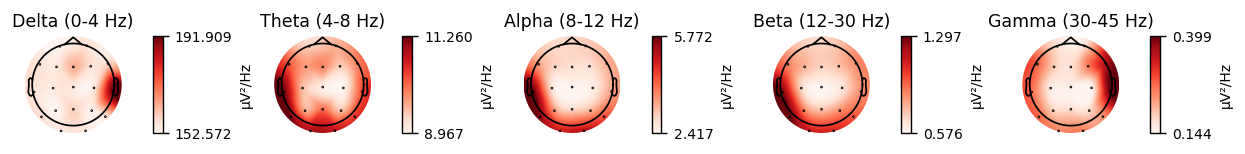

In [62]:
#a_raw[8].plot_psd(fmin=1., fmax=45.)
#matplotlib.use('Qt5Agg')
#c_raw[0][0].plot_psd_topomap(ch_type='eeg',fmin=0.5, fmax=45., normalize=False)


## Segmentation of raw EEG data

In [6]:
print("C duration mean")
print(np.mean(c_duration))
print("A duration mean")
print(np.mean(a_duration))

train_data_s,train_labels_s=segmentation(train_data, train_labels, segment_duration=20)

C duration mean
859.2913333333332
A duration mean
611.2846666666666
<RawEEGLAB | sub-039_task-eyesclosed_eeg.set, 19 x 425040 (850.1 s), ~61.6 MB, data loaded>
850.0
<RawEEGLAB | sub-043_task-eyesclosed_eeg.set, 19 x 414550 (829.1 s), ~60.1 MB, data loaded>
820.0
<RawEEGLAB | sub-062_task-eyesclosed_eeg.set, 19 x 449350 (898.7 s), ~65.2 MB, data loaded>
890.0
<RawEEGLAB | sub-017_task-eyesclosed_eeg.set, 19 x 421700 (843.4 s), ~61.2 MB, data loaded>
840.0
<RawEEGLAB | sub-025_task-eyesclosed_eeg.set, 19 x 342180 (684.4 s), ~49.6 MB, data loaded>
680.0
<RawEEGLAB | sub-003_task-eyesclosed_eeg.set, 19 x 153050 (306.1 s), ~22.2 MB, data loaded>
300.0


In [7]:
#print(train_labels_s)
#train_data_ob = np.array(train_data_s, dtype=object)
for a in train_data_s:
    print(a.shape)
   

(84, 19, 10001)
(81, 19, 10001)
(88, 19, 10001)
(83, 19, 10001)
(67, 19, 10001)
(29, 19, 10001)


In [84]:
from mne_connectivity import SpectralConnectivity
print(np.array(train_data_s[0][0]).shape)

connectivity = SpectralConnectivity(a_raw[0].get_data()[:][1],freqs=4,sfreq=500,n_nodes=19,method='plv', mode='fourier')
plt.plot(connectivity)

(19, 10001)


ValueError: different number of dimensions on data and dims: 1 vs 2

0.0


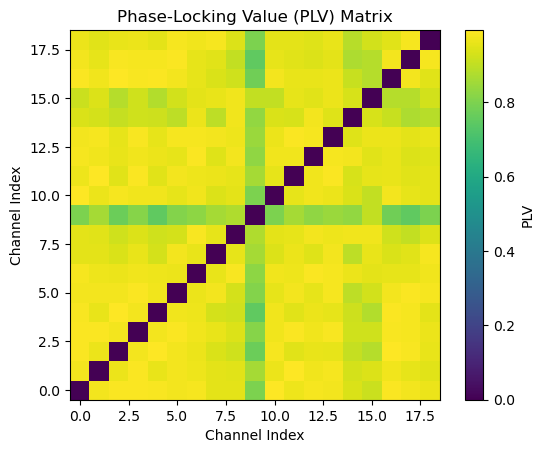

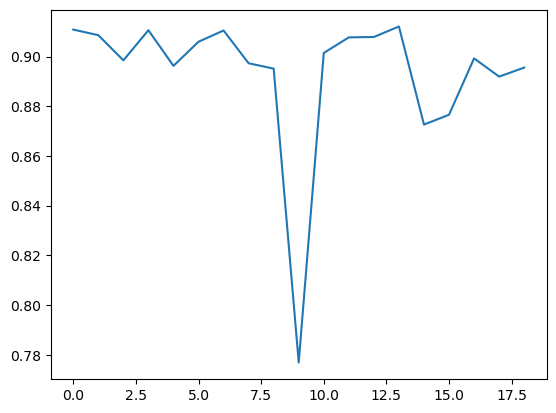

In [38]:
import numpy as np

def calculate_plv(data, sampling_rate):
    """
    Calculate Phase-Locking Value (PLV) for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - sampling_rate: Sampling rate of the time series data

    Returns:
    - plv_matrix: 2D numpy array representing PLV between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Frequency calculation
    frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)

    # Initialize PLV matrix
    plv_matrix = np.zeros((n_channels, n_channels))

    # Calculate PLV for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Compute Fourier transform for both channels
            fourier_i = np.fft.fft(data[i, :])
            fourier_j = np.fft.fft(data[j, :])

            # Compute phase difference
            phase_diff = np.angle(fourier_i / fourier_j)

            # Compute PLV
            plv = np.abs(np.mean(np.exp(1j * phase_diff)))

            # Store PLV in the matrix
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric

    return plv_matrix
import numpy as np
from scipy.signal import correlate


import numpy as np
from scipy.signal import cwt, coherence,morlet
import matplotlib.pyplot as plt

def calculate_cc(data, freqs= np.arange(1, 45+1, 1), scales=np.arange(1, 45+1,9)):
    """
    Calculate Wavelet Coherence for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - freqs: Array of frequencies for the wavelet transform
    - scales: Array of scales for the wavelet transform

    Returns:
    - wavelet_coherence_matrix: 2D numpy array representing Wavelet Coherence between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Initialize Wavelet Coherence matrix
    wavelet_coherence_matrix = np.zeros((n_channels, n_channels))

    # Calculate Wavelet Coherence for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Apply Continuous Wavelet Transform (CWT) to the signals
            cwt_i = cwt(data[i, :], morlet, scales)
            cwt_j = cwt(data[j, :], morlet, scales)

            # Calculate Coherence between the wavelet coefficients
            _, wavelet_coherence = coherence(cwt_i, cwt_j, fs=1, nperseg=500*4)

            # Store Wavelet Coherence in the matrix
            wavelet_coherence_matrix[i, j] = np.mean(wavelet_coherence)
            wavelet_coherence_matrix[j, i] = np.mean(wavelet_coherence)  # Wavelet Coherence is symmetric

    return wavelet_coherence_matrix




def plot_plv_matrix(plv_matrix):
    """
    Plot PLV matrix as a heatmap.

    Parameters:
    - plv_matrix: 2D numpy array representing PLV between all pairs of channels
    """

    plt.imshow(plv_matrix, cmap='viridis', origin='lower')
    plt.colorbar(label='PLV')
    plt.title('Phase-Locking Value (PLV) Matrix')
    plt.xlabel('Channel Index')
    plt.ylabel('Channel Index')
    plt.show()
# Example usage:
# Assuming 'your_data' is a 2D array with shape (19, 10001) and 'your_sampling_rate' is the sampling rate
index9=9
print(train_labels_s[index9][0])
#plv_result = calculate_plv(train_data_s[index9][0], 500)

plv_result = calculate_cc(train_data_s[index9][0])
average_plv = np.mean(plv_result, axis=1)
plot_plv_matrix(plv_result)
#plt.plot(plv_result,plv_result)
plt.plot(average_plv)


In [ ]:
import numpy as np
from scipy.signal import morlet, cwt, coherence
import matplotlib.pyplot as plt

def time_frequency_connectivity(data, sfreq, freq_band=(1, 45), n_cycles=7, method='coh'):
    """
    Calculate time-frequency connectivity using Morlet wavelets.

    Parameters:
        - data (numpy array): EEG or MEG data with shape (n_channels, n_times).
        - sfreq (float): Sampling frequency of the data.
        - freq_band (tuple): Frequency band of interest, e.g., (8, 13) for alpha.
        - n_cycles (int): Number of cycles for the Morlet wavelet.
        - method (str): Connectivity method, 'coh' for coherence, 'plv' for phase-locking value.

    Returns:
        - connectivity (numpy array): Time-frequency connectivity matrix.
        - times (numpy array): Time points corresponding to the connectivity matrix.
        - frequencies (numpy array): Frequencies corresponding to the connectivity matrix.
    """
    # Define frequency range and create Morlet wavelet
    fmin, fmax = freq_band
    frequencies = np.arange(fmin, fmax + 1)
    morlet_wavelet = morlet(c=2 * np.pi * n_cycles, w=frequencies / (2 * np.pi), s=1.0)

    # Calculate time-frequency connectivity
    connectivity = np.zeros((len(frequencies), data.shape[1]))
    for i, freq in enumerate(frequencies):
        wavelet_transform = cwt(data, morlet_wavelet(freq, 1 / sfreq), method='conv')
        if method == 'coh':
            connectivity[i, :], _, _, _ = coherence(wavelet_transform[0], wavelet_transform[1], fs=1/sfreq)
        elif method == 'plv':
            phase_diff = np.angle(wavelet_transform[0]) - np.angle(wavelet_transform[1])
            connectivity[i, :] = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))
        else:
            raise ValueError("Invalid method. Use 'coh' for coherence or 'plv' for phase-locking value.")

    times = np.arange(0, data.shape[1]) / sfreq

    return connectivity, times, frequencies

def plot_time_frequency_connectivity(connectivity, times, frequencies, method='coh'):
    """
    Plot time-frequency connectivity.

    Parameters:
        - connectivity (numpy array): Time-frequency connectivity matrix.
        - times (numpy array): Time points corresponding to the connectivity matrix.
        - frequencies (numpy array): Frequencies corresponding to the connectivity matrix.
        - method (str): Connectivity method, 'coh' for coherence, 'plv' for phase-locking value.
    """
    plt.imshow(connectivity, aspect='auto', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()])
    plt.colorbar(label='Connectivity')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    if method == 'coh':
        plt.title('Coherence Time-Frequency Connectivity')
    elif method == 'plv':
        plt.title('Phase-Locking Value Time-Frequency Connectivity')
    plt.show()

# Example usage:
# Replace 'your_data' and 'your_sfreq' with your actual EEG or MEG data and sampling frequency.
# The example below assumes 'your_data' is a 2-channel EEG signal with a sampling frequency of 200 Hz.

# your_data = np.random.rand(2, 1000)  # Replace with actual EEG or MEG data
your_sfreq = 500  # Replace with actual sampling frequency

connectivity, times, frequencies = time_frequency_connectivity(your_data, your_sfreq)
plot_time_frequency_connectivity(connectivity, times, frequencies, method='coh')


In [ ]:
plv_values_a = []


for raw_data in a_raw:
    print('nxt')
    plv_matrix_a = calculate_cc(raw_data.get_data())
    average_plv_a = np.mean(plv_matrix, axis=1)
  
    plv_values_a.append(plv_matrix_A)

# Convert the list of PLV matrices to a 3D numpy array
plv_values_array_a = np.array(plv_values_a)

nxt


C:\Anaconda\Lib\site-packages\scipy\signal\_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


In [ ]:
# Convert the list of PLV matrices to a 3D numpy array
plv_values_array_a = np.array(plv_values_a)
# Calculate the mean PLV across all iterations
print(plv_values_array_a.shape)
#average_coherence = np.mean(coherence_result, axis=1)
mean_plv_a = np.mean(plv_values_array_a, axis=0)

#plt.plot(mean_plv_a)
# Plot the mean PLV matrix
plt.imshow(mean_plv_a, cmap='viridis', origin='lower')
plt.colorbar(label='Mean PLV')
plt.title('Mean Phase-Locking Value (PLV) Matrix')
plt.xlabel('Channel Index')
plt.ylabel('Channel Index')
plt.show()

In [ ]:
plv_values_c = []


for raw_data in c_raw:
    print('nxt')
    #plv_matrix = calculate_cc(raw_data.get_data(), 500)
    plv_matrix_c = calculate_cc(raw_data.get_data())
    average_plv_c = np.mean(plv_matrix, axis=1)
    plv_values_c.append(plv_matrix)

In [ ]:
# Convert the list of PLV matrices to a 3D numpy array
plv_values_array_c = np.array(plv_values)

#average_coherence = np.mean(coherence_result, axis=1)
# Calculate the mean PLV across all iterations
mean_plv_c = np.mean(plv_values_array_c, axis=0)

#plt.plot(mean_plv)
# Plot the mean PLV matrix
plt.imshow(mean_plv_c, cmap='viridis', origin='lower')
plt.colorbar(label='Mean PLV')
plt.title('Mean Phase-Locking Value (PLV) Matrix')
plt.xlabel('Channel Index')
plt.ylabel('Channel Index')
plt.show()

## Extraction & plot of Mel-frequency cepstral coefficients (MFCCs) 

0.0


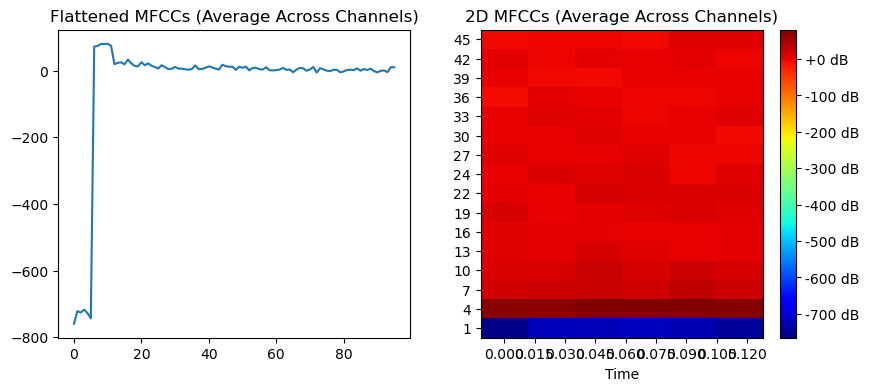

0.0


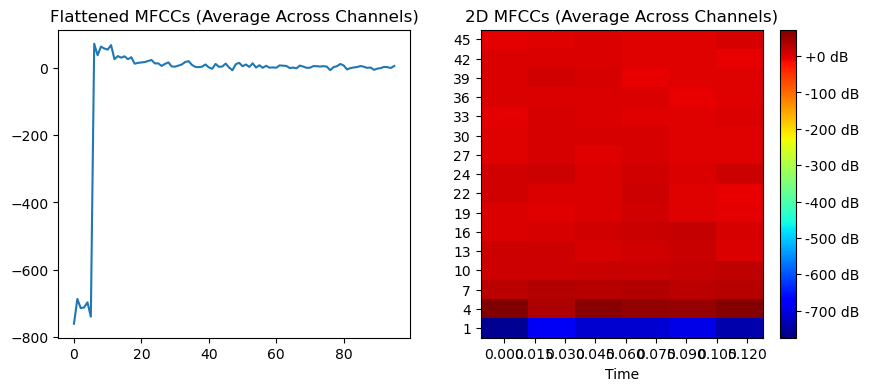

In [39]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def calculate_mfcc_and_plot(eeg_signal, sampling_rate=500, n_mfcc=16, window_size=4, overlap=0, low_freq=1, high_freq=45):

    # Calculate the number of samples per window and overlap
    samples_per_window = int(sampling_rate * window_size)
    hop_length = int(samples_per_window * (1 - overlap))

    # Initialize an empty list to store the MFCCs for each channel
    all_mfccs = []

    # Loop through each channel
    for channel_data in eeg_signal:
        # Calculate MFCCs for each channel
        mfccs = librosa.feature.mfcc(y=channel_data, sr=sampling_rate, n_mfcc=n_mfcc,
                                     n_fft=samples_per_window, hop_length=hop_length,
                                     fmin=low_freq, fmax=high_freq)
        all_mfccs.append(mfccs)

    # Stack the MFCCs along the channel axis
    stacked_mfccs = np.stack(all_mfccs, axis=-1)

    # Average the MFCCs across channels
    avg_mfccs = np.mean(stacked_mfccs, axis=-1)

    # Flatten MFCCs for MLP version
    flat_mfccs = avg_mfccs.flatten()

    # Plot flattened version
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(flat_mfccs.T)
    plt.title('Flattened MFCCs (Average Across Channels)')

    # Plot 2D version
    plt.subplot(1, 2, 2)
    librosa.display.specshow(avg_mfccs, x_axis='time', cmap='jet',  vmin=np.min(mfccs)) # Change the colormap here
    plt.colorbar(format='%+2.0f dB')
    plt.title('2D MFCCs (Average Across Channels)')
     # Add y-axis ticks with frequency values
    mel_frequencies = librosa.core.mel_frequencies(n_mfcc, fmin=low_freq, fmax=high_freq)
    plt.yticks(np.linspace(0, len(mel_frequencies)-1, n_mfcc), ['{:.0f}'.format(freq) for freq in mel_frequencies[::len(mel_frequencies)//n_mfcc]])
    # Show the plots
    plt.show()

    return flat_mfccs, avg_mfccs

# Example usage:
# Assuming eeg_signal is a 20-second EEG signal with shape (num_samples, 19)
# You need to replace this with your actual EEG signal data
# e.g., eeg_signal = np.random.rand(5000, 19)  # Replace with your actual EEG data

subjectindx=5
print(train_labels_s[subjectindx][0])
flat_mfccs, two_d_mfccs = calculate_mfcc_and_plot(train_data_s[subjectindx][0])

subjectindx=7
print(train_labels_s[subjectindx+1][0])
flat_mfccs, two_d_mfccs = calculate_mfcc_and_plot(train_data_s[subjectindx+1][0])


0.0


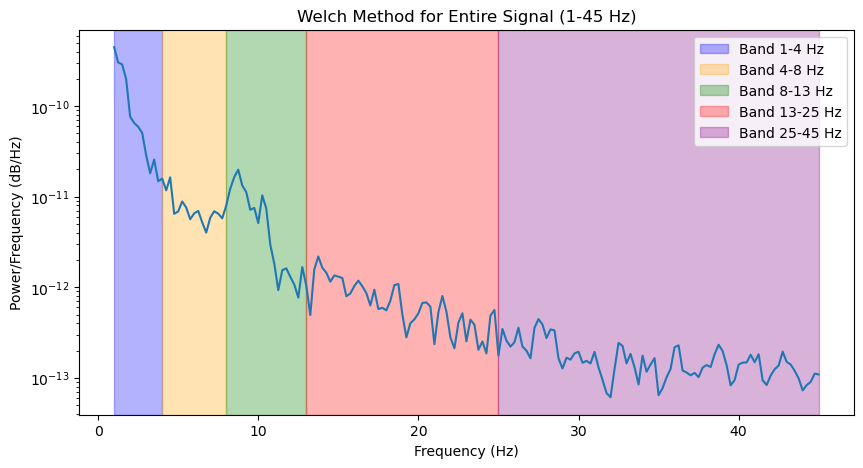

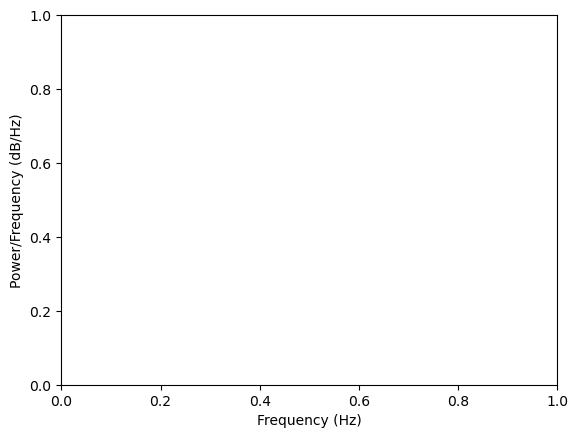

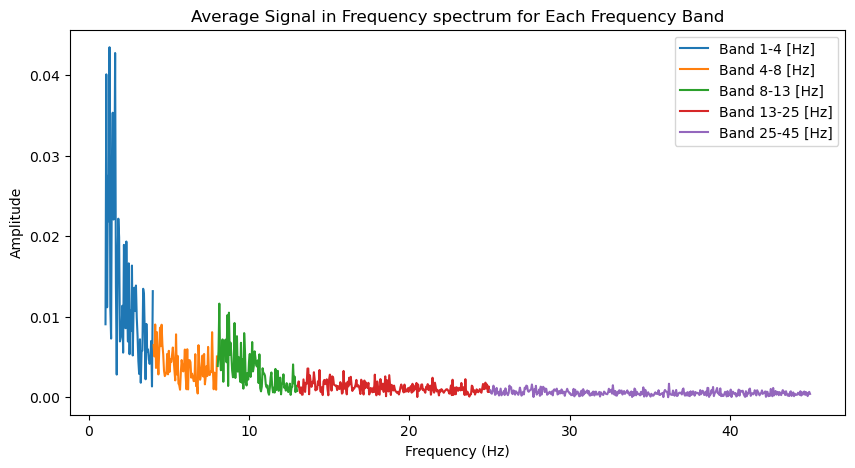

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def fourier_transform(signal, fs):
    # Perform Fourier Transform
    n = len(signal)
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(n, 1/fs)
    
    return freq, fft_result

def welch_method(signal, fs):
    # Calculate power spectral density (PSD) using Welch method
    freqs, psd = welch(signal, fs=fs, nperseg=fs*4, noverlap=fs*2)
    
    return freqs, psd

def visualize_fourier_welch(epoch_data, fs):
    # Plot Fourier Transform for the entire signal (constrained to 1-45 Hz)
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    avg_channel_signal = np.mean(epoch_data, axis=0)  # Calculate the average across all channels
   
    # Plot Welch method for the entire signal (constrained to 1-45 Hz)
    plt.figure(figsize=(10, 5))
    plt.title('Welch Method for Entire Signal (1-45 Hz)')
    
    avg_channel_signal = np.mean(epoch_data, axis=0)  # Calculate the average across all channels
    freqs, psd = welch_method(avg_channel_signal, fs)
    
    # Select frequency range
    freq_range = (freqs >= 1) & (freqs <= 45)
    
    plt.semilogy(freqs[freq_range], psd[freq_range])
      # Add colored bands
    band_colors = ['blue', 'orange', 'green', 'red', 'purple']
    for i, band in enumerate(frequency_bands):
        start_freq, end_freq = band
        plt.axvspan(start_freq, end_freq, color=band_colors[i], alpha=0.3, label=f'Band {start_freq}-{end_freq} Hz')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.legend()
    plt.show()
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # Plot the average time series signal for each frequency band
    # Define frequency bands
  

    plt.figure(figsize=(10, 5))
    plt.title('Average Signal in Frequency spectrum for Each Frequency Band')
    
    for band in frequency_bands:
        start_freq, end_freq = band

        # Fourier Transform
        freq, fft_result = fourier_transform(avg_channel_signal, fs)
        
        # Select frequency range
        freq_range = (freq >= start_freq) & (freq <= end_freq)
        
        # Plot average signal in time series for the selected frequency band
        plt.plot(freq[freq_range], np.abs(fft_result[freq_range]), label=f'Band {start_freq}-{end_freq} [Hz]')
            
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage
fs = 500
subject_index = 0
print(train_labels_s[subject_index][0])

visualize_fourier_welch(train_data_s[subject_index][0], fs)




0.0


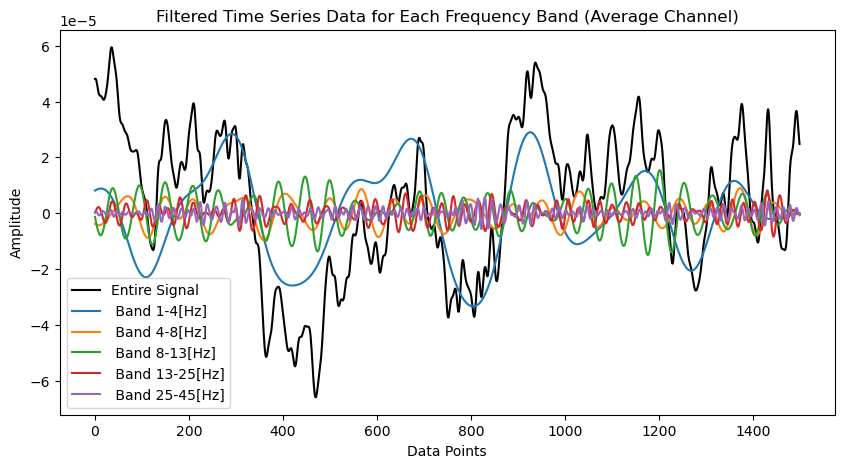

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def visualize_filtered_time_series_for_frequency_bands(channel_signal, fs,wstart,wend):
    # Define frequency bands
    
    avg_channel = np.mean(channel_signal, axis=0)
    avg_channel_signal=avg_channel[fs*wstart:fs*wend]
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]

    plt.figure(figsize=(10, 5))
    plt.title('Filtered Time Series Data for Each Frequency Band (Average Channel)')

    # Plot the entire time series data
    plt.plot(avg_channel_signal, label='Entire Signal', color='black')

    for band in frequency_bands:
        start_freq, end_freq = band
        
        # Filter the time series data for the selected frequency band
        filtered_time_series_band = butter_bandpass_filter(avg_channel_signal, start_freq, end_freq, fs)
        
        # Plot the filtered time series data for the selected frequency band
        plt.plot(filtered_time_series_band, label=f' Band {start_freq}-{end_freq}[Hz]')

    plt.xlabel('Data Points')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage
fs = 500
subject_index = 0
print(train_labels_s[subject_index][0])


visualize_filtered_time_series_for_frequency_bands(train_data_s[subject_index][0], fs,13,16)


## Extraction of Relative Band Power feature (RBP)

In [67]:
#!pip install mne_connectivity
import numpy as np
from scipy.signal import welch
from mne_connectivity import SpectralConnectivity
from mne_connectivity import spectral_connectivity_epochs
from sklearn.preprocessing import MinMaxScaler
from antropy import spectral_entropy as spectral_antropy # Assuming you have a method to compute spectral entropy



fs=500

def calculate_rbp(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
       
        
    rbp_features=np.array(rbp_features)
  
    rbp2d = rbp_features.reshape((19, 5, 1))
    
    return rbp_features,rbp2d

from scipy.signal import welch
import nolds


fs = 500

def calculate_rbp1(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    se_features = []
    
    epoch_data = epoch
    
    for i, channel_i in enumerate(epoch_data):
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel_i, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        subject_entropy = spectral_antropy(channel_i, sf=fs, nperseg=fs*4, method='welch', normalize=True)
        se_features.append(subject_entropy)
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)

        
    rbp_features = np.array(rbp_features)
    se_features = np.array(se_features)
    
    #print(rbp_features.shape) 
    #print(se_features.shape)
    
    se_features = se_features.reshape(-1, 1)
    
    plv=calculate_plv(epoch_data, 500)

    # Concatenate along the second axis
    concatenated_features = np.concatenate((rbp_features, se_features,plv), axis=1)
    
    #print(concatenated_features.shape)
   
    #print(concatenated_features.shape)
    concatenated_2d = concatenated_features.reshape((19, 25, 1))
    
    return concatenated_features, concatenated_2d





def calculate_rbp3(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for i, band in enumerate(frequency_bands):
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            
            # Scale bands 2 to 5 by 5x multiplier
            if i > 0:
                band_rbp *= 5
            
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
        
    rbp_features = np.array(rbp_features)
    reshaped_array = np.transpose(rbp_features, (1, 0))
    rbp2d = rbp_features.reshape((19, 5, 1))  # Adjust the shape according to your requirements
    
    return rbp_features, rbp2d



def calculate_rbp3(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]

    rbp_features = []
    epoch_data = epoch
    spectral_entropy_features = []
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)

        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins

        rbp = []

        subject_entropy = spectral_antropy(channel, sf=fs, nperseg=fs*4, method='welch', normalize=True)
        spectral_entropy_features.append(subject_entropy)

        for i, band in enumerate(frequency_bands):
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd

            rbp.append(band_rbp)

        rbp_features.append(rbp)

    # Convert lists to numpy arrays
    se = np.array(spectral_entropy_features)
    rbp_features = np.array(rbp_features)

    # Apply Min-Max scaling separately to each band and spectral entropy
    scaler = MinMaxScaler()
    scaled_rbp_features = []
    for band_idx in range(rbp_features.shape[1]):
        band_data = rbp_features[:, band_idx]
        band_data_scaled = scaler.fit_transform(band_data.reshape(-1, 1)).flatten()
        scaled_rbp_features.append(band_data_scaled)
    scaled_rbp_features = np.array(scaled_rbp_features).T

    scaled_se = scaler.fit_transform(se.reshape(-1, 1)).flatten()

    # Concatenate scaled features and reshape for the desired format
    concatenated_features = np.concatenate((scaled_rbp_features, scaled_se[:, np.newaxis]), axis=1)
    rbp2d = concatenated_features.reshape((19, 6, 1))

    return concatenated_features, rbp2d




# Initialize an empty list to store RBP features for all epochs

rbp_features_all_subjects = []
rbp2d_features_all_subjects = []


# Loop through each EEG epoch in train_data

for subject in train_data_s:
    rbp_features_all_segments = []
    rbp2d_features_all_segments = []
    print(subject.shape)
    for segment in subject:
        
        # Calculate RBP features for the current epoch
        rbp_features,rbp2d_features = calculate_rbp(segment, fs)
        #rbp_features = calculate_rbp_filter(segment, fs)
        rbp_features_all_segments.append(rbp_features)
        rbp2d_features_all_segments.append(rbp2d_features)
    
    rbp_features_all_subjects.append(np.array(rbp_features_all_segments))
    rbp2d_features_all_subjects.append(np.array(rbp2d_features_all_segments))




(84, 19, 10001)
(81, 19, 10001)
(88, 19, 10001)
(83, 19, 10001)
(67, 19, 10001)
(29, 19, 10001)


In [8]:
print(rbp_features_all_segments)

[array([[0.68301238, 0.12109104, 0.05450694, 0.07153955, 0.06985009,
        0.03464791, 0.01093915],
       [0.6647734 , 0.1291471 , 0.06013579, 0.06990072, 0.07604298,
        0.37996046, 0.05291503],
       [0.69999213, 0.12901018, 0.0565731 , 0.06201098, 0.0524136 ,
        0.20993006, 0.        ],
       [0.67758963, 0.13839108, 0.05994439, 0.06406345, 0.06001144,
        0.56343359, 0.00708578],
       [0.74870217, 0.14192399, 0.04651847, 0.03700646, 0.0258489 ,
        0.33428581, 0.03035596],
       [0.73518913, 0.1497879 , 0.04415938, 0.04126163, 0.02960196,
        0.64065902, 0.06776259],
       [0.654432  , 0.13002756, 0.14660976, 0.04519257, 0.02373812,
        0.6490069 , 0.8640311 ],
       [0.70841671, 0.14528993, 0.07538531, 0.04801577, 0.02289228,
        0.66389195, 0.37963291],
       [0.47663853, 0.10229087, 0.35749833, 0.04438266, 0.0191896 ,
        0.57699262, 1.        ],
       [0.53482323, 0.11366964, 0.28014291, 0.04971094, 0.02165329,
        0.02629559, 0.

## Converting to tensors

In [68]:
# Convert the list of RBP feature arrays to a NumPy array
#rbp_features_all_subjects = np.array(rbp_features_all_subjects)
#rbp2d_features_all_subjects = np.array(rbp2d_features_all_subjects)
#train_labels=np.array(train_labels_s)

# The shape of rbp_features_all_epochs is (number of epochs, number of frequency bands, number of channels)
for x in rbp_features_all_subjects:
    print("Shape of RBP features:", x.shape)
    #print("Shape of RBP features 2D:", y.shape)


raw_data = rbp_features_all_subjects[0]
print(raw_data.shape)  # This will show the shape of the EEG data

# Convert train_data and val_data to tensors of the same shape
train_data_rbp=rbp_features_all_subjects
train_data_rbp2d=rbp2d_features_all_subjects
#train_data_rbp = tf.convert_to_tensor(rbp_features_all_epochs, dtype=tf.float32)


train_labels.astype(int)
#train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)




Shape of RBP features: (84, 19, 5)
Shape of RBP features: (81, 19, 5)
Shape of RBP features: (88, 19, 5)
Shape of RBP features: (83, 19, 5)
Shape of RBP features: (67, 19, 5)
Shape of RBP features: (29, 19, 5)
(84, 19, 5)


array([0, 0, 0, 1, 1, 1])

## Visualisation of RBP feature 1D

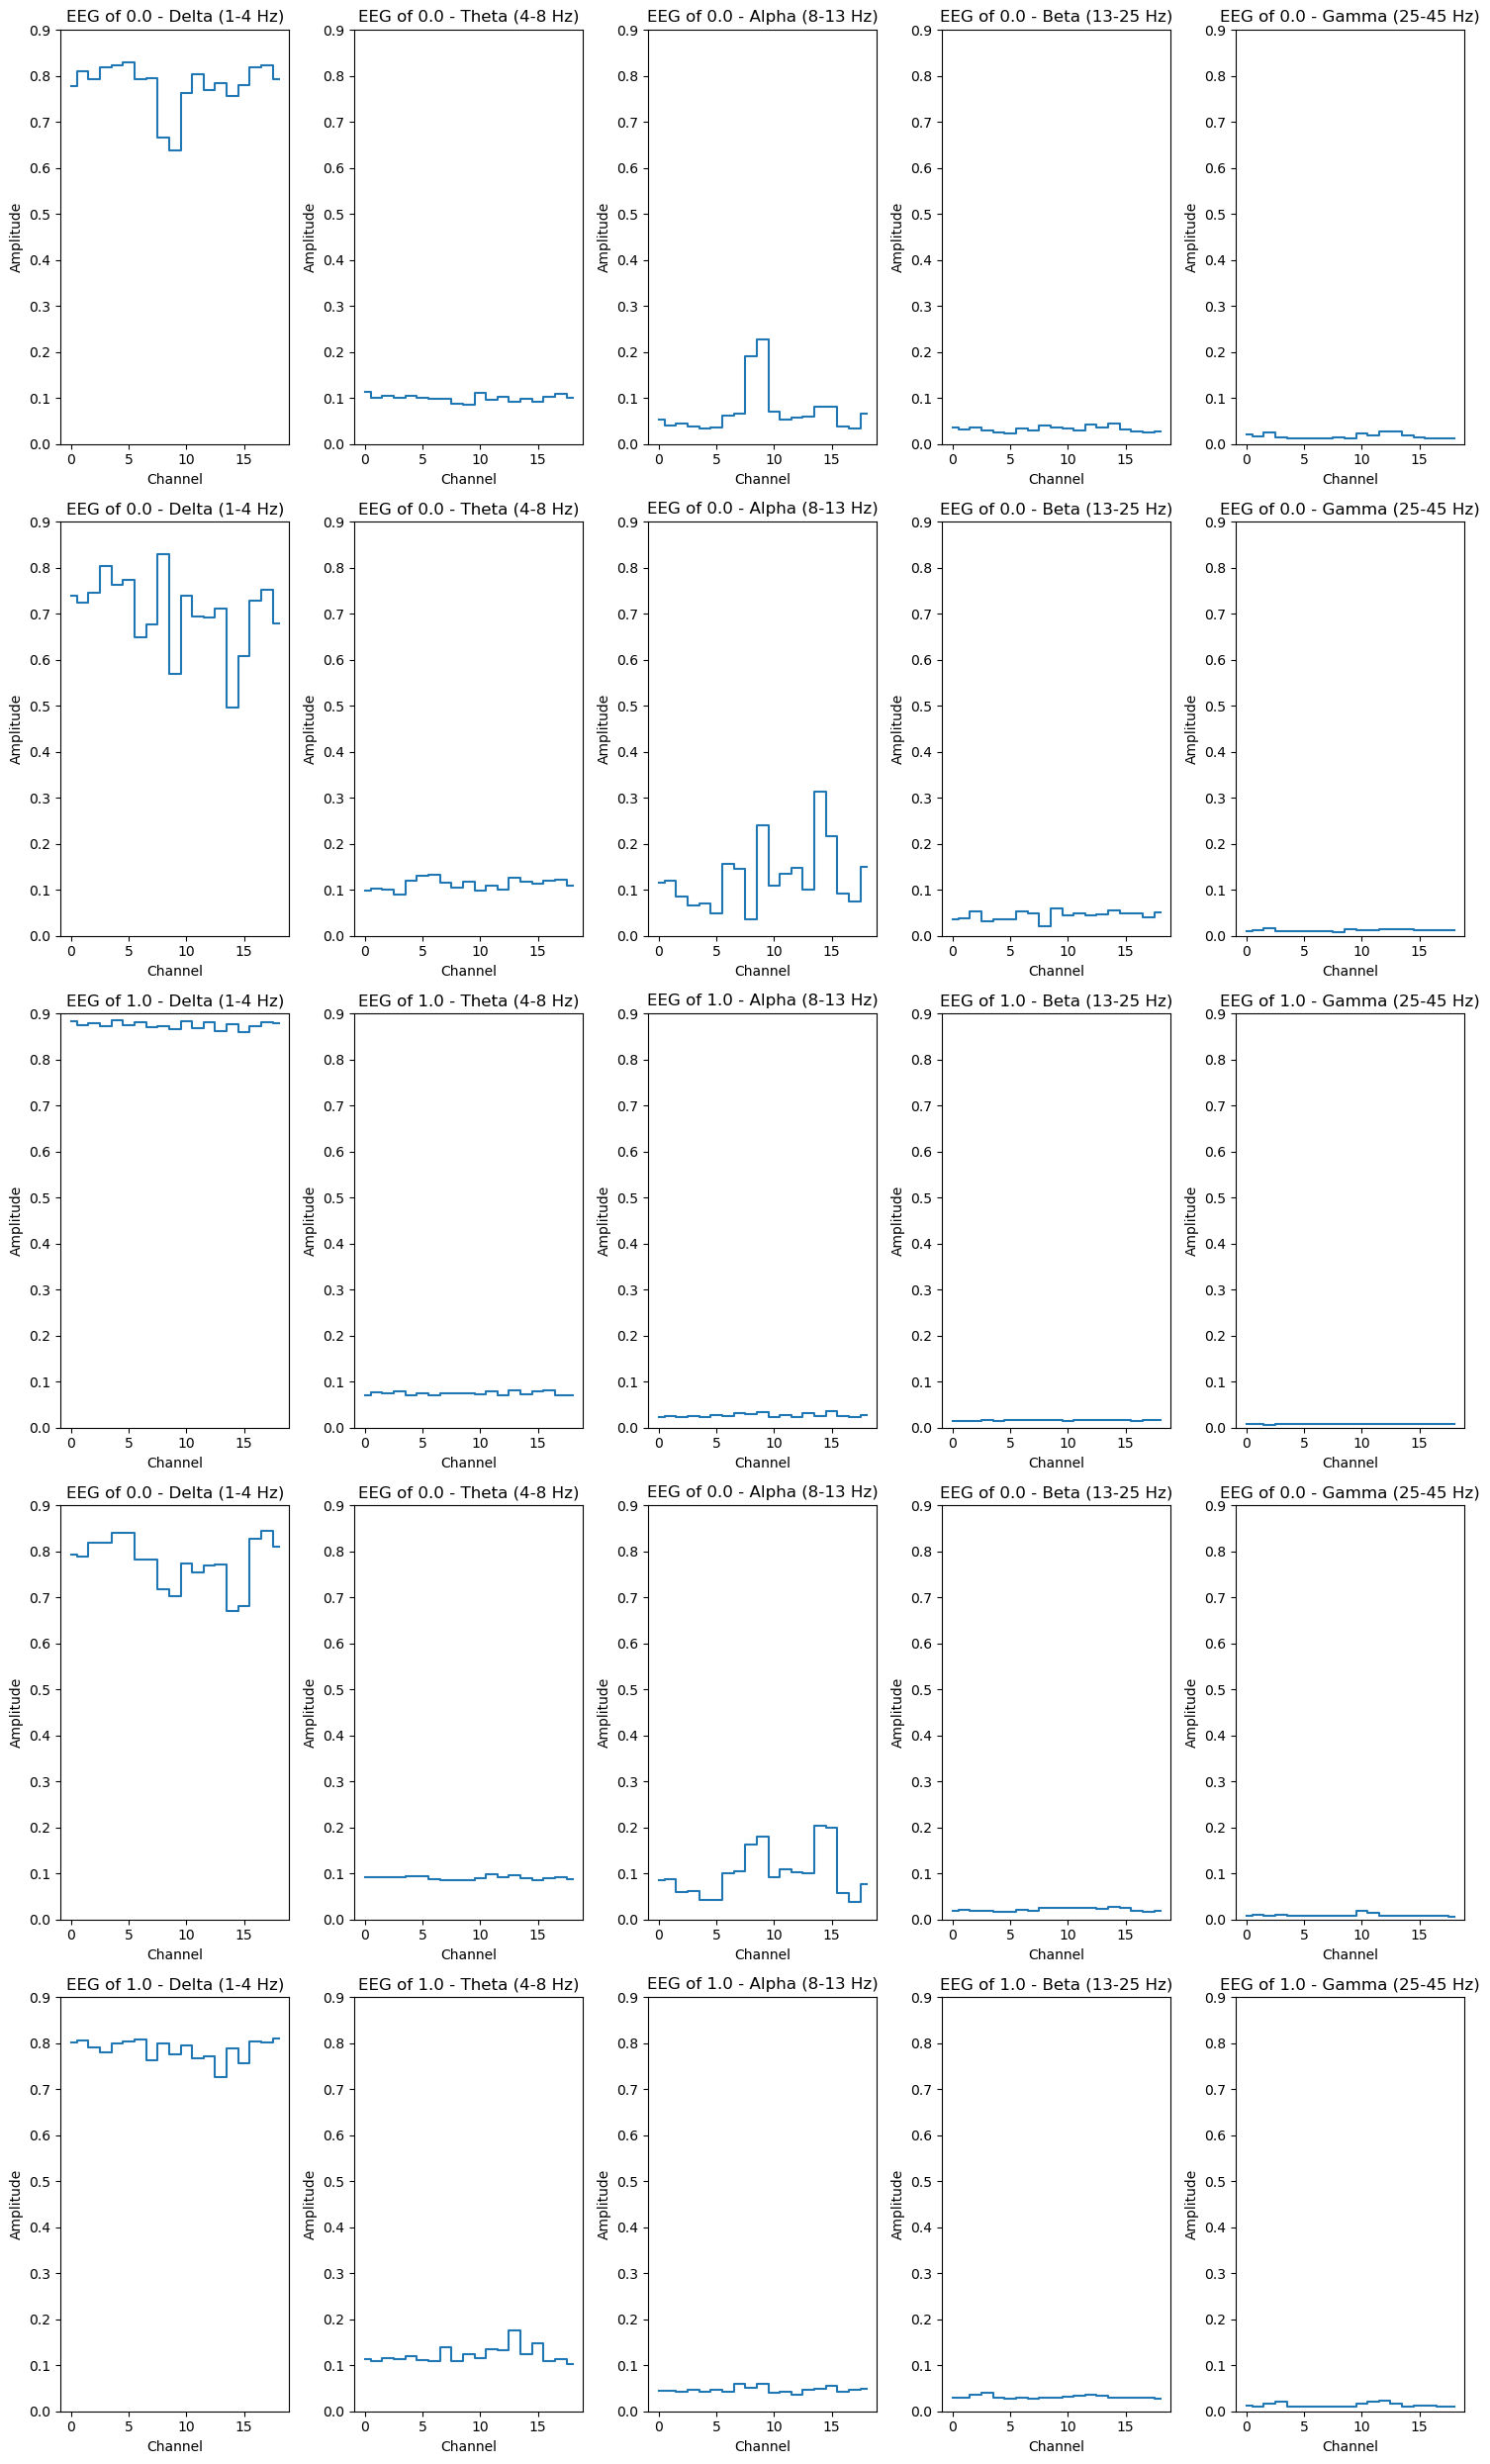

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_data_rbp is a list of variable-length sequences
# Assuming frequency_bands and frequency_band_names are defined
frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
frequency_band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
# Number of random epochs to display for each subject
num_epochs_to_display = 5

# Create a subplot with rows=num_epochs_to_display and columns=len(frequency_bands)
fig, axes = plt.subplots(num_epochs_to_display, len(frequency_bands), figsize=(15, 5*num_epochs_to_display))

for i in range(num_epochs_to_display):
    # Select a random subject index
    random_subject_index = np.random.randint(0, len(train_data_rbp))

    # Select a random epoch index from the chosen subject's data
    random_epoch_index = np.random.randint(0, len(train_data_rbp[random_subject_index]))

    # Get the random subject's data and corresponding label
    random_subject_data = train_data_rbp[random_subject_index][random_epoch_index]
    random_label = train_labels_s[random_subject_index][random_epoch_index]

    for j, (freq_band, freq_band_name) in enumerate(zip(frequency_bands, frequency_band_names)):
        ax = axes[i, j]
        ax.step(np.arange(len(random_subject_data)), random_subject_data[:, j], where='mid')
        ax.set_title(f'EEG of {random_label} - {freq_band_name} ({freq_band[0]}-{freq_band[1]} Hz)')
        ax.set_xlabel('Channel')
        ax.set_ylabel('Amplitude')

        # Set y-axis limits from 0 to 1
        ax.set_ylim(0, 0.9)

plt.tight_layout()
plt.show()





## Visualisation of RBP feature 2D

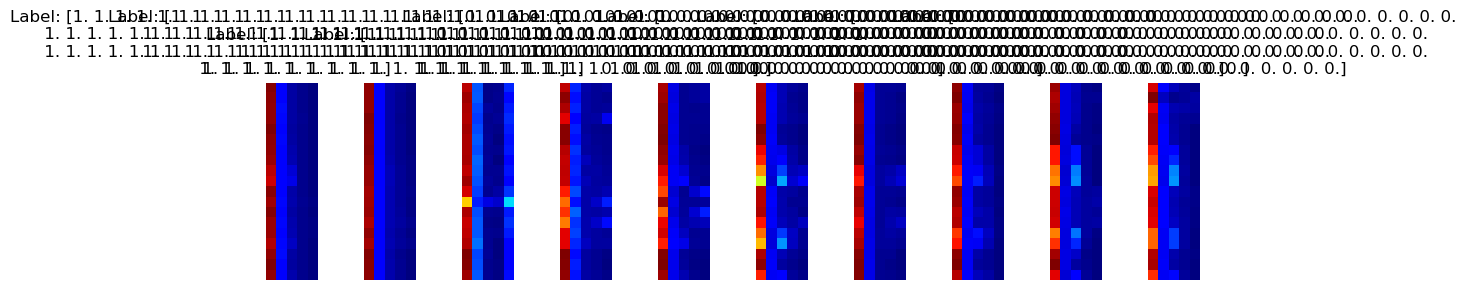

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_data_rbp2d is a list of 2D arrays and train_labels is a list of corresponding labels
# Replace these with your actual data

# Number of random subjects to display
num_subjects_to_display = 10

# Create a subplot with rows=1 and columns=num_subjects_to_display
fig, axes = plt.subplots(1, num_subjects_to_display, figsize=(1*num_subjects_to_display, 3))

for i in range(num_subjects_to_display):
    # Select a random subject from your dataset
    random_subject_index = np.random.randint(0, len(train_data_rbp2d))
    random_subject_data = train_data_rbp2d[random_subject_index]
    random_subject_label = train_labels_s[random_subject_index]
    
    # Select a random epoch from the chosen subject
    num_epochs = random_subject_data.shape[0]  # Assuming epochs are along the first axis
    random_epoch_index = np.random.randint(0, num_epochs)
    random_epoch_data = random_subject_data[random_epoch_index]
    
    # Display the random epoch image with its label
    axes[i].imshow(random_epoch_data, cmap='jet')  # You can choose your preferred colormap
    axes[i].set_title(f"Label: {random_subject_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()



## Model CNN 2D

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Add, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model

def create_CNN2D_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    bn1 = BatchNormalization()(input_layer)

    # First Convolutional Layer with Batch Normalization and ReLU activation
    conv1 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu')(bn1)
    #conv1 = BatchNormalization()(conv1)

    # Second Convolutional Layer with Batch Normalization and ReLU activation
    conv2 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu')(conv1)
    #conv2 = BatchNormalization()(conv2)
    
   
    #conv3 = BatchNormalization()(conv2)
    
    # Skip Connection from Input to Output of Conv1
    #skip_connection = Add()([conv1, conv2])

    # Flatten the output of the last Conv2D layer
    flatten = Flatten()(conv2)
    batch_norm3= BatchNormalization()(flatten)
    
    # Fully connected layers
    dense1 = Dense(8, activation='relu')(batch_norm3)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(8, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    output_layer = Dense(1, activation='sigmoid')(dropout2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage
input_shape = train_data_rbp2d[0][0].shape
model_CNN2D = create_CNN2D_model(input_shape)
model_CNN2D.summary()


In [21]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization,Reshape

def create_CNN2D_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    bn1 = BatchNormalization()(input_layer)

    # First Convolutional Layer with Batch Normalization and ReLU activation
    conv1 = Conv2D(filters=4, kernel_size=(2, 2), activation='relu', padding='same')(bn1)

    # Second Convolutional Layer with Batch Normalization and ReLU activation
    conv2 = Conv2D(filters=4, kernel_size=(2, 2), activation='relu', padding='same')(conv1)
    
    
    # Skip Connection from Input to Output of Conv1
    skip_connection = Add()([conv1, conv2])

    # Transformer Block
  

    # Flatten the output of the Transformer block
    flatten = Flatten()(skip_connection)
    batch_norm3 = BatchNormalization()(flatten)

    # Fully connected layers
    dense1 = Dense(8, activation='relu')(batch_norm3)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(8, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    output_layer = Dense(1, activation='sigmoid')(dropout2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage
input_shape = train_data_rbp2d[0][0].shape
model_CNN2D = create_CNN2D_model(input_shape)
model_CNN2D.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 19, 25, 1)]          0         []                            
                                                                                                  
 batch_normalization_8 (Bat  (None, 19, 25, 1)            4         ['input_2[0][0]']             
 chNormalization)                                                                                 
                                                                                                  
 conv2d_2 (Conv2D)           (None, 19, 25, 4)            20        ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                            

## Model RNN

## Model CNN 1D MULTI-HEAD

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Lambda,SpatialDropout1D, Conv2D,SpatialDropout2D,Conv1D, Dropout,MaxPooling1D,DepthwiseConv1D,SeparableConv1D, AveragePooling1D, Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add

def model_CNN_1D_multi_head_BUILD(input_shape):
    # Create the input layer
    input_layer = Input(shape=input_shape)
    #input_layer2d = Input(shape=input_shape2d)
 
    #print("Input layer Shape:", input_layer.shape)
    sequence_length = input_shape[0]  # Assuming input_shape is (channels, frequency bands)


    # Add batch normalization after the input layer
    #x = BatchNormalization()(input_layer)
    flat_x = Flatten()(input_layer)

    # Define the convolutional heads
    def convolutional_head(kernel_size,input_tensor):
        conv1 = Conv1D( filters=4,kernel_size=kernel_size, activation='relu',padding='same')(input_tensor)
        conv1 = BatchNormalization()(conv1)
        #pool = MaxPooling1D(pool_size=2)(conv)  # Use AveragePooling1D instead of MaxPooling1D
        conv2 = Conv1D( filters=4,kernel_size=kernel_size, activation='relu',padding='same')(conv1)
        conv2 = BatchNormalization()(conv2)
        
        skip_connection = Add()([conv1, conv2])
        skip_connection1 = BatchNormalization()(skip_connection)
        #spatial_dropout=SpatialDropout1D(0.25)(pool)
        #conv2 = Conv1D(filters=4, kernel_size=kernel_size, activation='relu')(spatial_dropout)
        normalized_flat = Flatten()(skip_connection1)
        return normalized_flat
    
    

 

    def convolutional_head_2D(kernel_size, input_layer):
        input_tensor = Reshape((input_layer.shape.as_list()[1], input_layer.shape.as_list()[2], 1))(input_layer)
        # First Convolutional Layer with Batch Normalization and ReLU activation
        conv1 = Conv2D(filters=4, kernel_size=kernel_size, activation='relu',padding='same')(input_tensor)
        conv1 = BatchNormalization()(conv1)
  

        # Second Convolutional Layer with Batch Normalization and ReLU activation
        conv2 = Conv2D(filters=4, kernel_size=kernel_size, activation='relu',padding='same')(conv1)
        conv2 = BatchNormalization()(conv2)
        
        skip_connection = Add()([conv1, conv2])
        skip_connection1 = BatchNormalization()(skip_connection)
        # Flatten the output of the last Conv2D layer
        flattened = Flatten()(skip_connection1)

        return flattened



    #flat1 = convolutional_head(1)
    flat3 = convolutional_head(3,input_layer)
    #flat5 = convolutional_head(5,input_layer)
    #flat7 =  convolutional_head(7)
   
    
    flat2D_31=convolutional_head_2D((3,3),input_layer)

    # Concatenate the outputs of all convolutional heads
    #concatenated = Concatenate()([flat_x,flat_delta, flat_theta, flat_alpha, flat_beta, flat_gamma,flat3,flat5,flat2D_31])
    concatenated = Concatenate()([flat_x,flat3,flat2D_31])
    
    normalized1 = BatchNormalization()(concatenated)
     # Add batch normalization, pooling, and dropout layers
    #dropout = Dropout(0.2)(concatenated)

  
    dense_layer3 = Dense(8, activation='relu')(normalized1)
    dropout4 = Dropout(0.2)(dense_layer3)
    dense_layer5 = Dense(8, activation='relu')(dropout4)
    dropout5 = Dropout(0.2)(dense_layer5)
    output_layer = Dense(1, activation='sigmoid')(dropout5)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


# Define the input shape (adjust the 'input_shape' to match your data shape)
input_shape = train_data_rbp[0][0].shape 
print(input_shape)

# Create the model using the function
model_CNN_1D_multi_head = model_CNN_1D_multi_head_BUILD(input_shape)

# Print the model summary
model_CNN_1D_multi_head.summary()


(19, 25)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 19, 25)]             0         []                            
                                                                                                  
 reshape (Reshape)           (None, 19, 25, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 19, 4)                304       ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 19, 25, 4)            40        ['reshape[0][0]']             
                                                                                     

In [30]:

import pydot

from IPython.display import display
from tensorflow.keras.utils import plot_model

# Visualize the model architecture in the Jupyter Notebook
plot_model(model_CNN2D, show_shapes=True, show_layer_names=True)

# Display the model diagram inline in the Jupyter Notebook
display()




You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Train data statistics

0


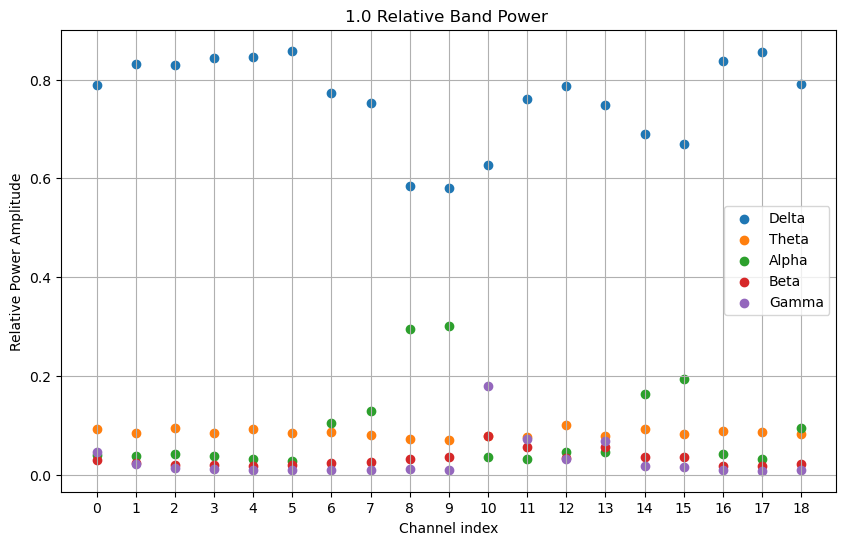

In [119]:
#print("train_data_rbp shape:", train_data_rbp.shape)
#print("train_data_rbp data type:", train_data_rbp.dtype)

#print("train_labels shape:", train_labels.shape)
#print("train_labels data type:", train_labels.dtype)
#print(train_labels_s)
labelC1=0
#for t in train_labels:
#    if(t==0):
#        labelC1 += 1
        
print(labelC1)
#print(train_data_rbp[0])
min_value = 0  # Minimum value for index3
max_value = 5  # Maximum value for index3
index3 = random.randint(min_value, max_value)
#print(train_labels[index3])
#plt.step(range(len(train_data_rbp[index3][index3])), train_data_rbp[index3][index3], where='mid')

# Assuming train_data_rbp[index3][index3] has shape (19, 5)
y_values = train_data_rbp[index3][index3]

plt.figure(figsize=(10, 6))
for i in range(y_values.shape[1]):
    plt.scatter(range(len(y_values)), y_values[:, i], label=f'Set {i+1}')

#plt.plot(train_data_rbp[index3])
plt.title(f'{train_labels_s[index3][index3]} Relative Band Power ')

plt.legend(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])

plt.xlabel('Channel index')
plt.ylabel('Relative Power Amplitude')
plt.xticks(range(len(y_values)))  # Set x-axis ticks to integers
plt.grid()
plt.show()




(98002, 6)


IndexError: tuple index out of range

1.0


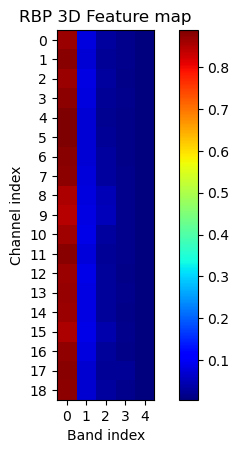

In [131]:
import numpy as np
import matplotlib.pyplot as plt

index3 = random.randint(min_value, max_value)
print(train_labels[index3])


# Reshape the data to (19, 5, 1)
train_data_rbp2D = train_data_rbp[index3][index3].reshape((19,5, 1))


# Plot the EEG data as an image
plt.imshow(train_data_rbp2D[:, :, 0], cmap='jet')  # You can choose a different colormap if needed
plt.title('RBP 3D Feature map')
plt.ylabel('Channel index')
plt.xlabel('Band index')
plt.yticks(range(len(y_values)))  # Set x-axis ticks to integers
plt.xticks(range(0,5))  # Set y-axis ticks to integers

plt.colorbar()
plt.show()

# Now, if you want to use this data as input to a CNN2D, you may need to further preprocess it based on your model's requirements.


## Model MLP training loop

In [40]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random 


train_labels=train_labels_s

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_channels = train_data_rbp[0][0].shape[0]
num_frequency_bands = train_data_rbp[0][0].shape[1]

loo = LeaveOneOut()

average_accuracy = []

confusion_true_MLP = []
confusion_pred_MLP = []

histories_MLP=[]

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()
    model_MLP = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(num_channels, num_frequency_bands)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # BINARY CLASSIFICATION 1 NEURON
    ])

    
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_MLP.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])
                
    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train the model
    history_MLP = model_MLP.fit(train_data_reshaped, np.array(train_labels_concat),
                                epochs=20, batch_size=16, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_MLP.append(history_MLP)

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data
    test_pred = model_MLP.predict(test_data)

    # Convert prediction to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy manually
    test_acc = np.mean(test_pred_binary == test_labels_concat)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_MLP.extend(test_labels_concat)
    confusion_pred_MLP.extend(test_pred_binary.flatten())

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/57


IndexError: index 74 is out of bounds for axis 0 with size 74

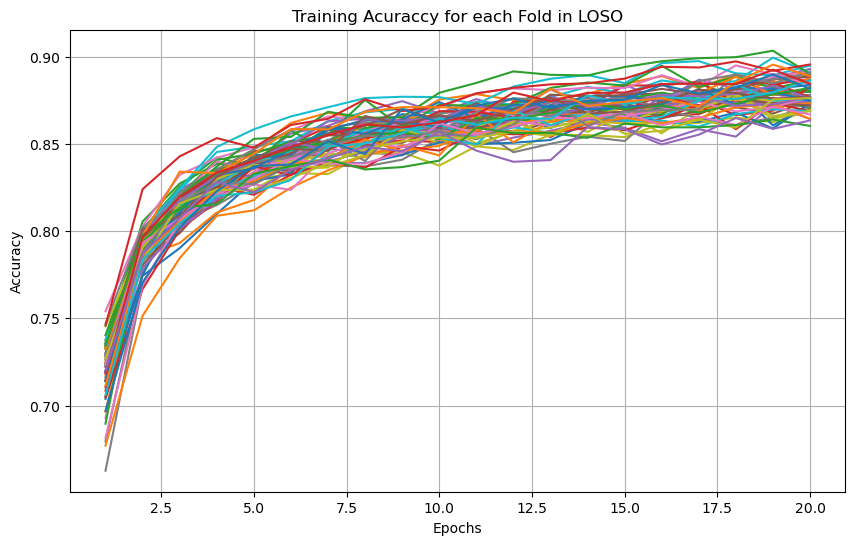

In [16]:
plot_accuracy(histories_MLP)

Accuracy: 0.7583700019131433
Precision: 0.7807881773399015
Sensitivity (Recall): 0.7761455054214761
Specificity: 0.7369087837837838
F1-score: 0.7784599193124013


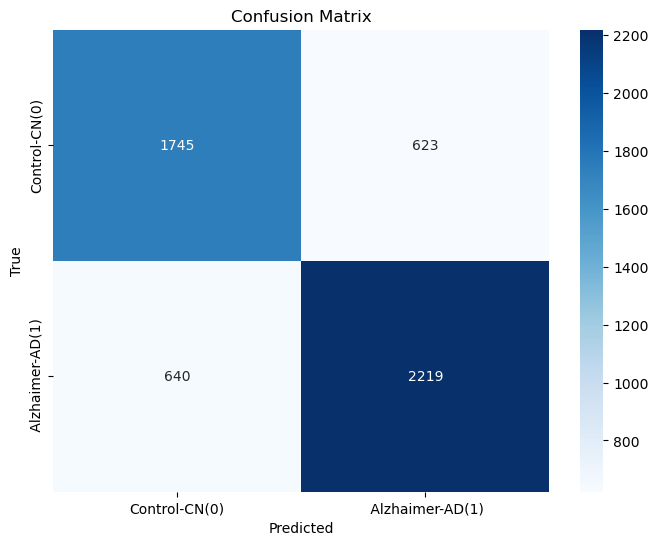

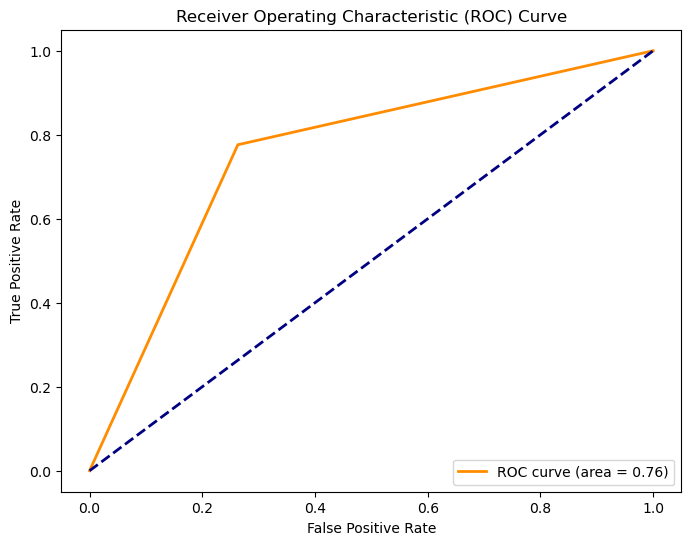

In [19]:

calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP)

## Model CNN 1D MULTI-HEAD  training loop

In [137]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix

train_labels=train_labels_s

learning_rate = 0.002  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

loo = LeaveOneOut()

average_accuracy = []
confusion_true_CNN = []
confusion_pred_CNN = []
histories_CNN = []

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()
    model_CNN_1D_multi_head = model_CNN_1D_multi_head_BUILD((num_channels, num_frequency_bands))
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN_1D_multi_head.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    # Separate current subject's data for testing
    test_data = np.array(train_data_rbp[subject_idx])
    test_labels_concat = np.array(train_labels[subject_idx])

    # Combine data from other subjects for training
    train_data = []
    train_labels_concat = []
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            train_data.extend(data)
            train_labels_concat.extend(train_labels[idx])

    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train the model
    history_CNN = model_CNN_1D_multi_head.fit(train_data_reshaped, np.array(train_labels_concat),
                                             epochs=15, batch_size=16, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_CNN.append(history_CNN)

    # Predict on test data
    test_pred = model_CNN_1D_multi_head.predict(test_data)

    # Convert prediction to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy and confusion matrix
    test_acc = accuracy_score(test_labels_concat, test_pred_binary)
    confusion_true_CNN.extend(test_labels_concat)
    confusion_pred_CNN.extend(test_pred_binary.flatten())

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")

# Calculate and print confusion matrix
#confusion_matrix_CNN = confusion_matrix(confusion_true_CNN, confusion_pred_CNN)
#print("Confusion Matrix:")
#print(confusion_matrix_CNN)



Leave-One-Subject-Out: Testing on subject 1/65
Epoch 1/15
322/322 [==============================] - 6s 8ms/step - loss: 0.4465 - accuracy: 0.7890 - lr: 0.0020
Epoch 2/15
322/322 [==============================] - 2s 7ms/step - loss: 0.3751 - accuracy: 0.8350 - lr: 0.0020
Epoch 3/15
322/322 [==============================] - 3s 9ms/step - loss: 0.3456 - accuracy: 0.8519 - lr: 0.0020
Epoch 4/15
322/322 [==============================] - 3s 8ms/step - loss: 0.3228 - accuracy: 0.8587 - lr: 0.0020
Epoch 5/15
322/322 [==============================] - 2s 7ms/step - loss: 0.3071 - accuracy: 0.8677 - lr: 0.0020
Epoch 6/15
322/322 [==============================] - 2s 7ms/step - loss: 0.2804 - accuracy: 0.8859 - lr: 0.0020
Epoch 7/15
322/322 [==============================] - 2s 7ms/step - loss: 0.2751 - accuracy: 0.8865 - lr: 0.0020
Epoch 8/15
322/322 [==============================] - 2s 8ms/step - loss: 0.2548 - accuracy: 0.8976 - lr: 0.0020
Epoch 9/15
322/322 [=============================

Accuracy: 0.7020833333333333
Precision: 0.6471449487554904
Sensitivity (Recall): 0.5717981888745148
Specificity: 0.7898866608544028
F1-score: 0.6071428571428571


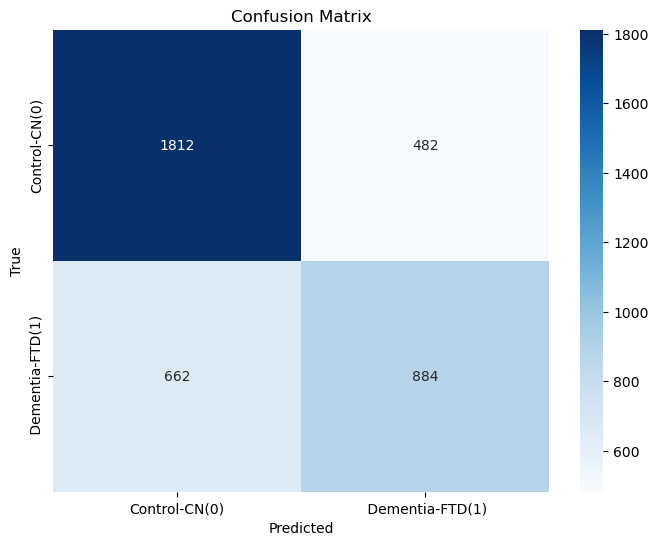

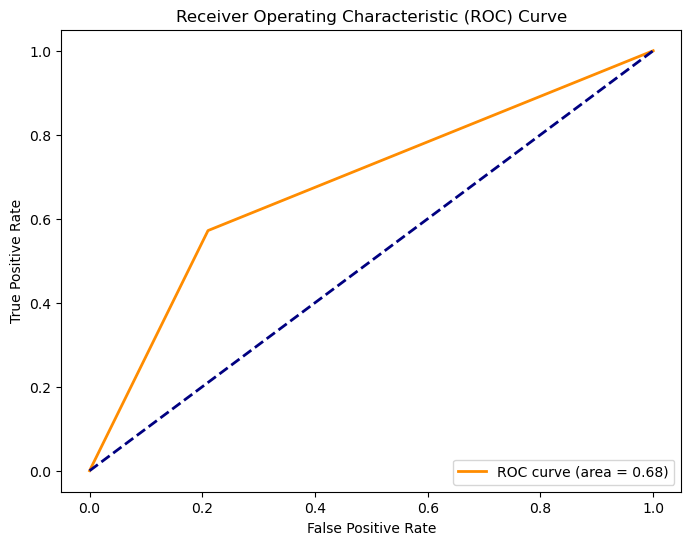

In [52]:
calculate_metrics_and_plot(confusion_true_CNN, confusion_pred_CNN)

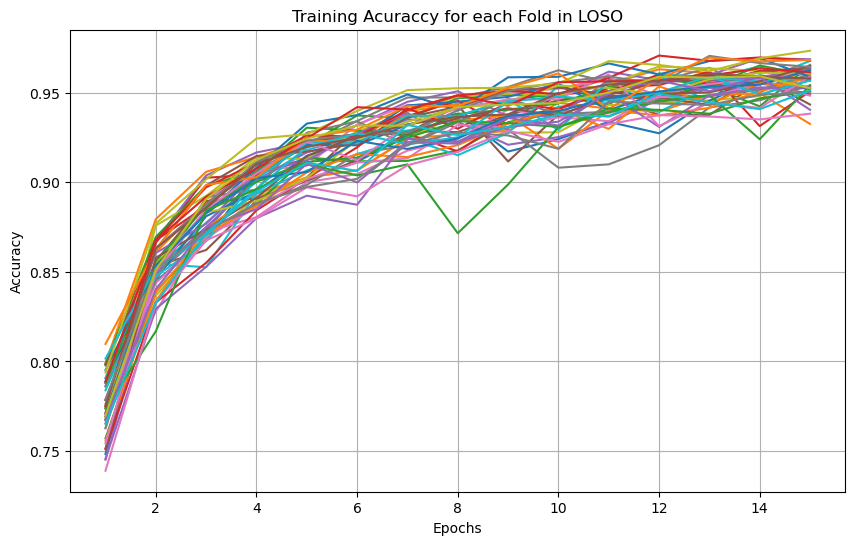

In [26]:
plot_accuracy(histories_CNN)

## Model CNN 2D training loop

In [102]:
print(train_data_rbp2d[0][0].shape)

(19, 10, 1)


In [24]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random

train_labels=train_labels_s

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]


learning_rate = 0.003  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)

num_subjects = len(train_data_rbp2d)

loo = LeaveOneOut()

average_accuracy = []

confusion_true_CNN2D = []
confusion_pred_CNN2D = []  # Changed from confusion_pred_MLP

histories_CNN2D = []  # Changed from histories_MLP

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()

    # Define the CNN2D model
       # Assuming input_shape is the shape of your input data
    input_shape = train_data_rbp2d[0][0].shape

    model_CNN2D=create_CNN2D_model(input_shape)
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN2D.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])
    
    train_data_concat = []
    train_labels_concat = []
    # Construct the training set excluding current subject's data
    for idx, data in enumerate(train_data_rbp2d):
        if idx != subject_idx:
            # Concatenate data along the first axis (axis=0)
            train_data_concat.extend(data)
            # Concatenate labels
            train_labels_concat.extend(train_labels[idx])

    # Concatenate the lists of arrays to create final numpy arrays
    
    #train_data_concatenated = np.concatenate(train_data_concat, axis=0)
    #train_data_concatenated=np.array(train_data_concat)
    train_labels_concatenated = np.array(train_labels_concat)

    # Reshape the training data to match the model's input shape
    #train_data_reshaped = train_data_concatenated.reshape(-1, num_channels, num_frequency_bands, 1)
    train_data_reshaped = np.array(train_data_concat).reshape(-1, num_channels, num_frequency_bands,1)
    # Train the CNN2D model
    history_CNN2D = model_CNN2D.fit(train_data_reshaped, train_labels_concatenated,
                                     epochs=15, batch_size=128, verbose=1, callbacks=[EarlyStop, ReduceLR])

    histories_CNN2D.append(history_CNN2D)

    # Test on the current subject's data
    test_data = np.array(train_data_rbp2d[subject_idx])
    test_labels = np.array(train_labels[subject_idx])

    # Predict using the CNN2D model
    test_pred = model_CNN2D.predict(test_data)

    # Convert predictions to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy manually
    test_acc = np.mean(test_pred_binary.flatten() == test_labels)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_CNN2D.extend(test_labels)  # Changed from confusion_true_MLP
    confusion_pred_CNN2D.extend(test_pred_binary.flatten())  # Changed from confusion_pred_MLP

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/65
Epoch 1/15
41/41 [==============================] - 3s 23ms/step - loss: 0.5710 - accuracy: 0.7025 - lr: 0.0030
Epoch 2/15
41/41 [==============================] - 1s 23ms/step - loss: 0.4672 - accuracy: 0.7701 - lr: 0.0030
Epoch 3/15
41/41 [==============================] - 1s 23ms/step - loss: 0.4017 - accuracy: 0.8167 - lr: 0.0030
Epoch 4/15
41/41 [==============================] - 1s 23ms/step - loss: 0.3512 - accuracy: 0.8417 - lr: 0.0030
Epoch 5/15
41/41 [==============================] - 1s 26ms/step - loss: 0.3004 - accuracy: 0.8742 - lr: 0.0030
Epoch 6/15
41/41 [==============================] - 1s 24ms/step - loss: 0.2788 - accuracy: 0.8757 - lr: 0.0030
Epoch 7/15
41/41 [==============================] - 1s 26ms/step - loss: 0.2385 - accuracy: 0.8948 - lr: 0.0030
Epoch 8/15
41/41 [==============================] - 1s 24ms/step - loss: 0.2097 - accuracy: 0.9072 - lr: 0.0030
Epoch 9/15
41/41 [==============================] - 1s 24

Accuracy: 0.7149416491295199
Precision: 0.737261698440208
Sensitivity (Recall): 0.7439664218258132
Specificity: 0.6798986486486487
F1-score: 0.7405988857938719


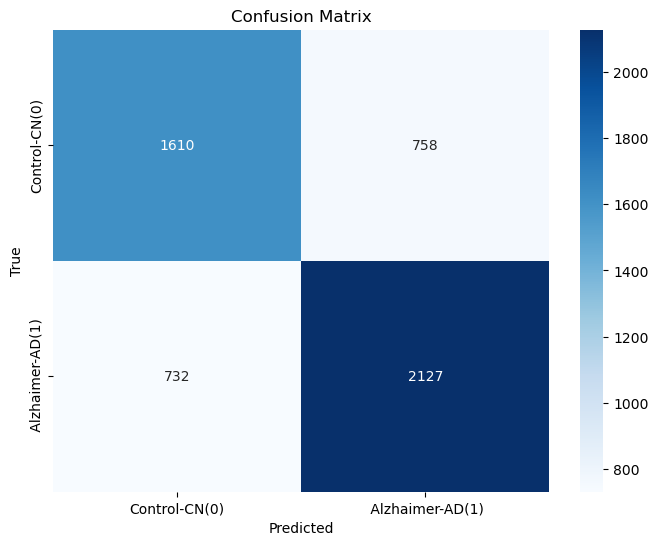

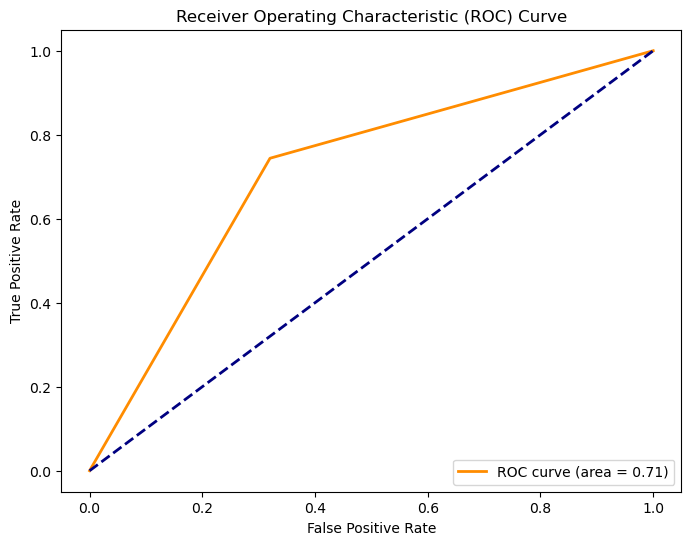

In [25]:
calculate_metrics_and_plot(confusion_true_CNN2D, confusion_pred_CNN2D)

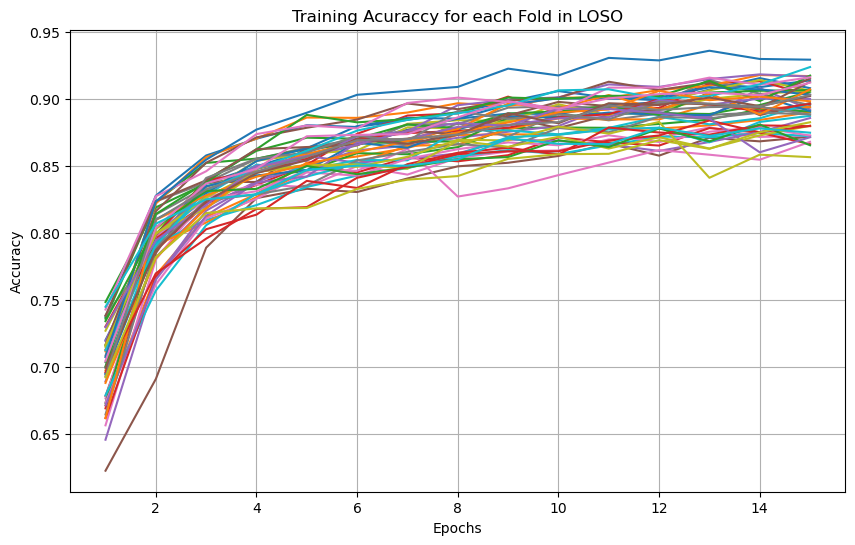

In [29]:
plot_accuracy(histories_CNN2D)


1/1 [==============================] - 0s 38ms/step


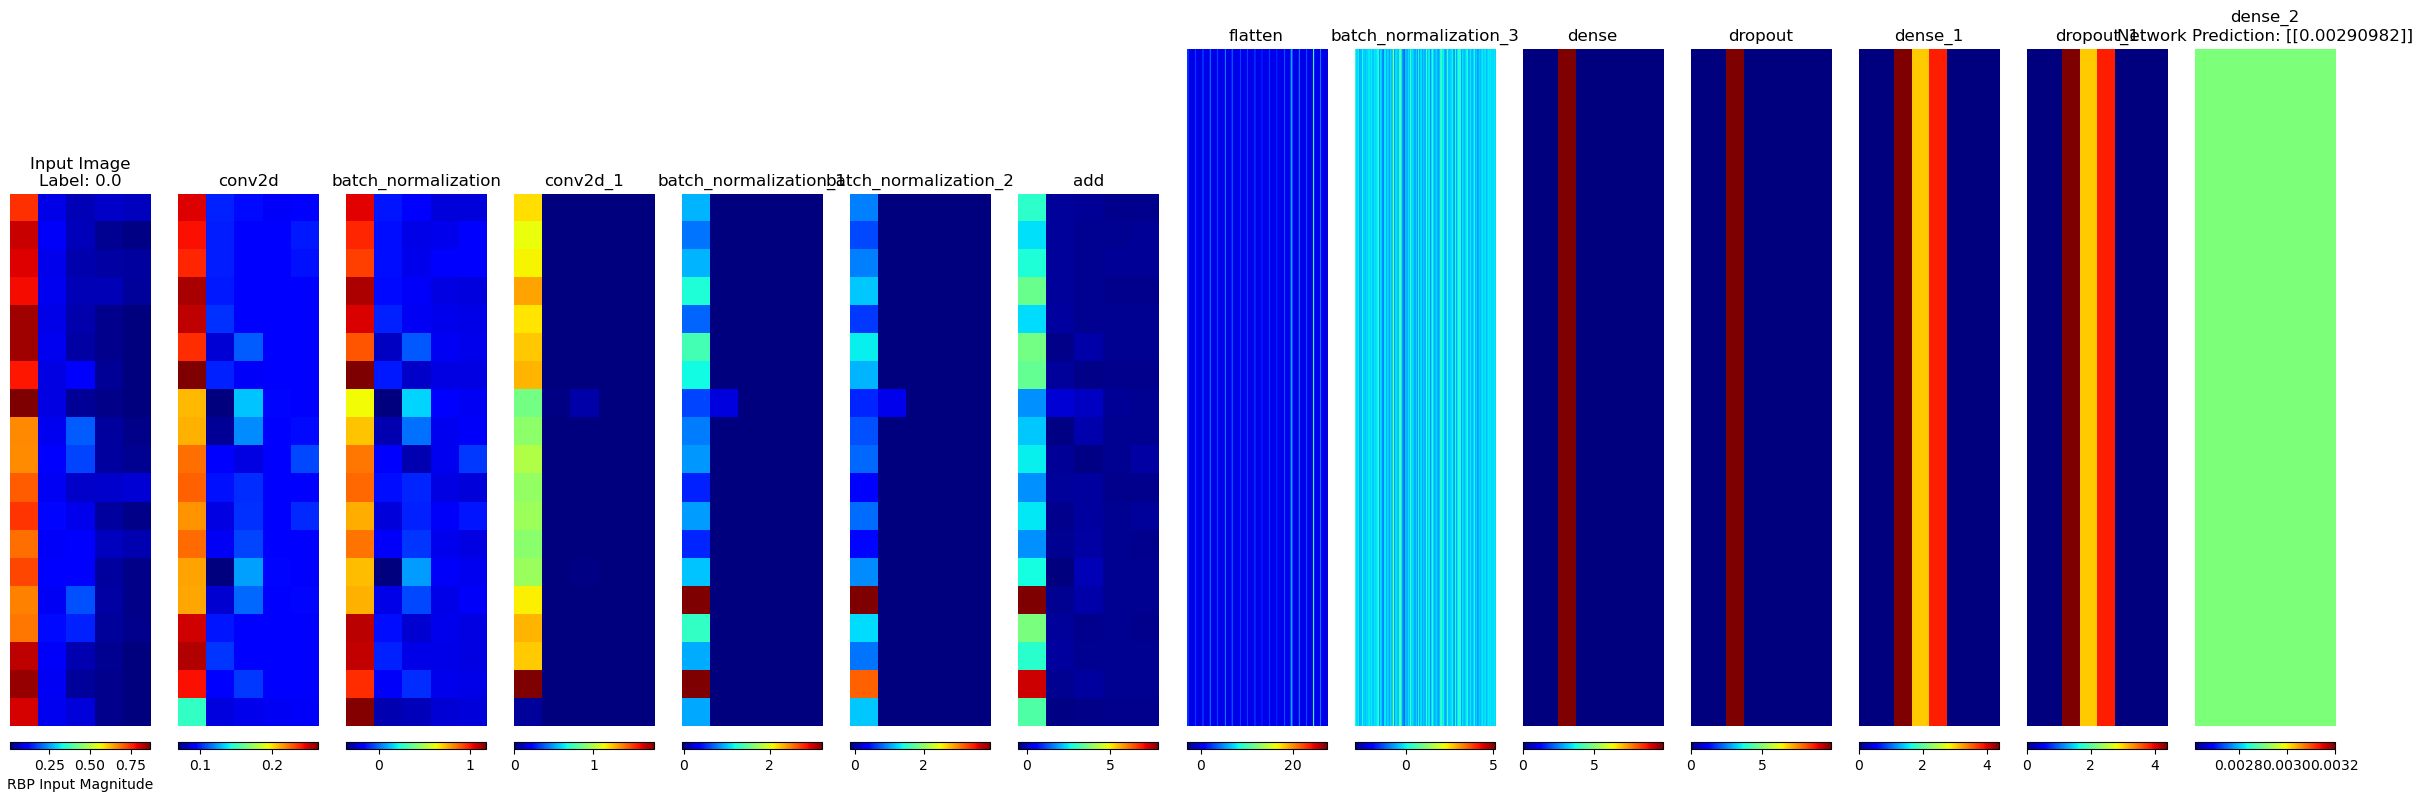

In [30]:
def visualize_activation_maps(model, samples, labels, colormap):
    random_subject_index = np.random.randint(len(samples))
    random_epoch_index = np.random.randint(samples[random_subject_index].shape[0])
    sample = np.expand_dims(samples[random_subject_index][random_epoch_index], axis=0)  # Random subject and epoch
    label = labels[random_subject_index][random_epoch_index]  # Corresponding label

    layer_outputs = [layer.output for layer in model.layers[1:]]  # Skip input layer and flatten layer
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(sample)

    # Original sample
    plt.figure(figsize=(30, 10))
    
    plt.subplot(1, len(activations) + 1, 1)
    plt.imshow(np.squeeze(sample[0]), cmap=colormap)
    plt.title('Input Image\nLabel: {}'.format(label))
    plt.axis('off')
    # Add a colorbar to explain magnitudes of the displayed colors
    cbar = plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
    cbar.set_label('RBP Input Magnitude')  # You can customize the colorbar label if needed


    # Activation maps for each layer
    for i, (layer_name, activation_map) in enumerate(zip([layer.name for layer in model.layers[1:]], activations)):
        plt.subplot(1, len(activations) + 1, i + 2)
        if len(activation_map.shape) == 4:  # 4D activation map (batch_size, width, height, channels)
            # Average activation across channels
            avg_activation = np.mean(activation_map[0], axis=-1)
            plt.imshow(avg_activation, cmap=colormap)
            plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
        elif len(activation_map.shape) == 2:  # 2D activation map (batch_size, features)
            plt.imshow(np.expand_dims(activation_map[0], axis=0), cmap=colormap, aspect='auto')
            plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
        plt.title(layer_name)
        plt.axis('off')

    # Print the network prediction under the title of the last activation map
    prediction = model.predict(sample)
    plt.title('{}\nNetwork Prediction: {}'.format(layer_name, prediction))
    
    # Add a colorbar to explain magnitudes of the displayed colors
    #cbar2 = plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
    #cbar2.set_label('Prediction Magnitude')  # You can customize the colorbar label if needed

    plt.show()

# Example usage
colormap = 'jet'
visualize_activation_maps(model_CNN2D, train_data_rbp2d, train_labels, colormap)


In [113]:
from IPython.display import display
from tensorflow.keras.utils import plot_model

# Visualize the model architecture in the Jupyter Notebook
plot_model(model_CNN2D, show_shapes=True, show_layer_names=True)

# Display the model diagram inline in the Jupyter Notebook
display()


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


1/1 [==============================] - 0s 138ms/step


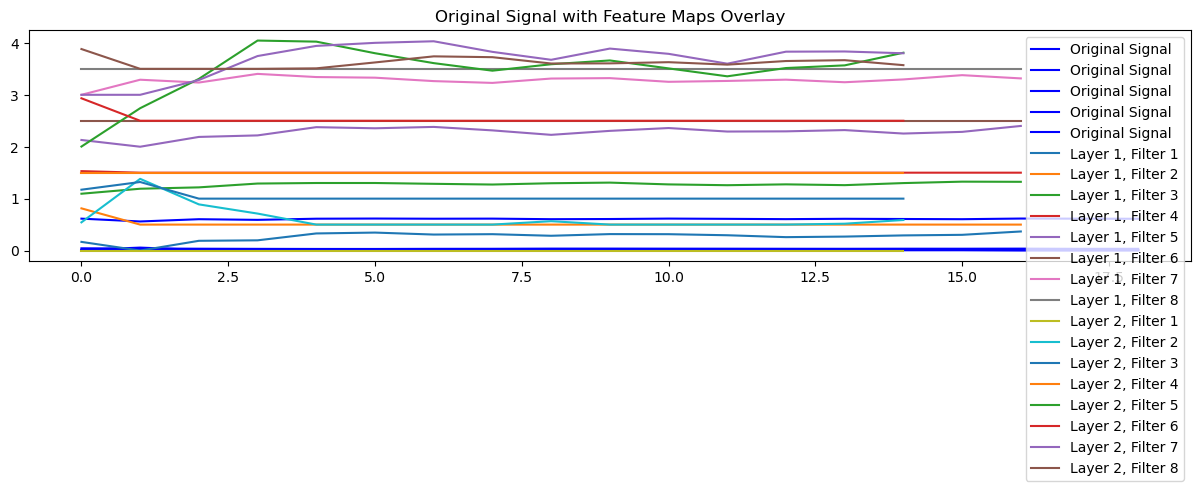

In [76]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def visualize_convolution_layers_overlay(model, input_signal):
    # Define a function to extract the outputs of intermediate layers
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv1D)]
    
    # Create a new model that outputs the intermediate layer activations
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Reshape the input signal to match the model's input shape
    input_signal = input_signal.reshape(1, num_channels,num_frequency_bands)  # Adjust the shape accordingly
    
    # Get the intermediate layer activations
    activations = activation_model.predict(input_signal)
    
    # Plot the original signal
    plt.figure(figsize=(15, 3))
    plt.plot(input_signal[0, :, :], label='Original Signal', color='blue')
    
    # Plot the feature maps for each convolutional layer
    for layer_index, layer_activation in enumerate(activations):
        num_filters = layer_activation.shape[-1]
        num_columns = min(num_filters, 8)  # Display up to 8 filters
        
        for filter_index in range(num_columns):
            plt.plot(layer_activation[0, :, filter_index] + 0.5 * filter_index, label=f'Layer {layer_index+1}, Filter {filter_index+1}')
    
    plt.title('Original Signal with Feature Maps Overlay')
    plt.legend()
    plt.show()

# Assuming you have your input signal as "input_signal"
# Call the function to visualize the feature maps overlaid on the original signal
visualize_convolution_layers_overlay(model_CNN_1D, train_data_rbp[0])


## Model RNN training loop

In [57]:
#!pip install torch
import torch
import torch.nn as nn

class GraphConvolutionLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolutionLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adjacency_matrix):
        # x is the input node features
        # adjacency_matrix is the graph adjacency matrix
        
        # Perform graph convolution operation
        x = torch.matmul(adjacency_matrix, x)  # Aggregating information from neighbors
        x = self.linear(x)  # Apply linear transformation
        
        return x

In [ ]:
#!pip install torch torchvision torch-geometric

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
import random

# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_channels = train_data_rbp[0][0].shape[0]
num_frequency_bands = train_data_rbp[0][0].shape[1]

class GNNModel(nn.Module):
    def __init__(self, num_channels, num_features, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_channels, num_features)
        self.conv2 = GCNConv(num_features, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.sigmoid(x)

learning_rate = 0.005
num_features = 16  # Number of features in the hidden layer
num_classes = 1  # Output classes (binary classification)

average_accuracy = []

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    model_gnn = GNNModel(num_channels, num_features, num_classes)
    optimizer = optim.Adam(model_gnn.parameters(), lr=learning_rate)

    # Construct the training set excluding current subject's epochs
    train_data = []
    train_labels_concat = []

    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])

    # Create a graph data structure using PyTorch Geometric Data class
    x = torch.tensor(train_data, dtype=torch.float32)
    edge_index = torch.tensor([[i, j] for i in range(len(train_data)) for j in range(i + 1, len(train_data))], dtype=torch.long).t().contiguous()
    edge_index = edge_index.to('cuda') if torch.cuda.is_available() else edge_index
    data = Data(x=x, edge_index=edge_index)

    # Train the model
    model_gnn = model_gnn.to('cuda') if torch.cuda.is_available() else model_gnn
    data = data.to('cuda') if torch.cuda.is_available() else data
    train_loader = DataLoader([data], batch_size=8, shuffle=True)

    for epoch in range(25):
        model_gnn.train()
        for batch in train_loader:
            optimizer.zero_grad()
            output = model_gnn(batch.x, batch.edge_index)
            labels = torch.tensor(train_labels_concat, dtype=torch.float32).view(-1, 1)
            labels = labels.to('cuda') if torch.cuda.is_available() else labels
            loss = nn.BCELoss()(output, labels)
            loss.backward()
            optimizer.step()

    # Test on the current subject's epochs
    test_data = torch.tensor(train_data_rbp[subject_idx], dtype=torch.float32)
    test_data = test_data.to('cuda') if torch.cuda.is_available() else test_data
    test_edge_index = torch.tensor([[i, j] for i in range(len(test_data)) for j in range(i + 1, len(test_data))], dtype=torch.long).t().contiguous()
    test_edge_index = test_edge_index.to('cuda') if torch.cuda.is_available() else test_edge_index
    test_data = Data(x=test_data, edge_index=test_edge_index)

    model_gnn.eval()
    with torch.no_grad():
        test_output = model_gnn(test_data.x, test_data.edge_index)
        test_labels = torch.tensor(train_labels[subject_idx], dtype=torch.float32).view(-1, 1)
        test_labels = test_labels.to('cuda') if torch.cuda.is_available() else test_labels
        test_loss = nn.BCELoss()(test_output, test_labels)
        test_pred_binary = (test_output > 0.5).float()
        test_acc = torch.mean((test_pred_binary == test_labels).float()).item()
        print(f"Test Accuracy: {test_acc:.4f}")
        print("=" * 30)

    average_accuracy.append(test_acc)

average_accuracy = torch.tensor(average_accuracy, dtype=torch.float32)
average_accuracy = average_accuracy.mean().item()
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")



Leave-One-Subject-Out: Testing on subject 1/64


In [17]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random

train_labels=train_labels_s

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

average_accuracy_RNN = []
confusion_true_RNN = []
confusion_pred_RNN = []
histories_RNN = []

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()

    # RNN Model
    model_RNN = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, num_channels * num_frequency_bands), input_shape=(num_channels, num_frequency_bands)),
    tf.keras.layers.BatchNormalization(),
    
    # First SimpleRNN layer
    tf.keras.layers.SimpleRNN(8, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.2),

    # Second SimpleRNN layer
    tf.keras.layers.SimpleRNN(4, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation='sigmoid')  # BINARY CLASSIFICATION 1 NEURON
    ])


    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    # Compile RNN Model
    model_RNN.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])

    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train RNN Model
    history_RNN = model_RNN.fit(train_data_reshaped, np.array(train_labels_concat),
                                epochs=20, batch_size=8, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_RNN.append(history_RNN)

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data for RNN
    test_pred_RNN = model_RNN.predict(test_data)
    threshold_RNN = 0.5
    test_pred_binary_RNN = (test_pred_RNN > threshold_RNN).astype(int)
    
    confusion_true_RNN.extend(test_labels_concat)  # Changed from confusion_true_MLP
    confusion_pred_RNN.extend(test_pred_binary_RNN.flatten())  # Changed from confusion_pred_MLP


    # Calculate accuracy manually for RNN
    test_acc_RNN = np.mean(test_pred_binary_RNN == test_labels_concat)
    print(f"RNN Test Accuracy: {test_acc_RNN:.4f}")

    print("=" * 30)

    average_accuracy_RNN.append(test_acc_RNN)

average_accuracy_RNN = np.mean(average_accuracy_RNN)
print(f"Average RNN Test Accuracy: {average_accuracy_RNN:.4f}")
print("Leave-One-Subject-Out validation complete.")


Leave-One-Subject-Out: Testing on subject 1/50
Epoch 1/20
471/471 [==============================] - 4s 3ms/step - loss: 0.5780 - accuracy: 0.6591 - lr: 0.0050
Epoch 2/20
471/471 [==============================] - 1s 3ms/step - loss: 0.4938 - accuracy: 0.7526 - lr: 0.0050
Epoch 3/20
471/471 [==============================] - 1s 3ms/step - loss: 0.4614 - accuracy: 0.7807 - lr: 0.0050
Epoch 4/20
471/471 [==============================] - 2s 4ms/step - loss: 0.4339 - accuracy: 0.8001 - lr: 0.0050
Epoch 5/20
471/471 [==============================] - 2s 4ms/step - loss: 0.3997 - accuracy: 0.8176 - lr: 0.0050
Epoch 6/20
471/471 [==============================] - 2s 4ms/step - loss: 0.4222 - accuracy: 0.8041 - lr: 0.0050
Epoch 7/20
471/471 [==============================] - 2s 4ms/step - loss: 0.4092 - accuracy: 0.8073 - lr: 0.0050
Epoch 8/20
471/471 [==============================] - 2s 4ms/step - loss: 0.4058 - accuracy: 0.8139 - lr: 0.0050
Epoch 9/20
461/471 [============================>

Accuracy: 0.6877604166666667
Precision: 0.6089139987445072
Sensitivity (Recall): 0.6274256144890039
Specificity: 0.7284219703574543
F1-score: 0.6180312201338005


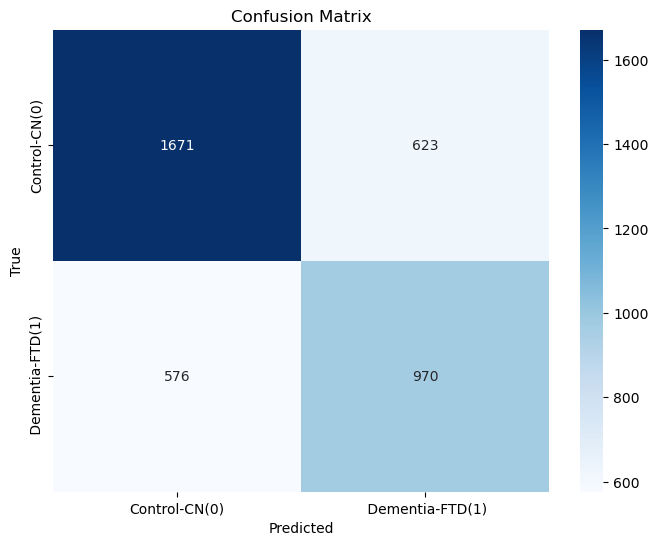

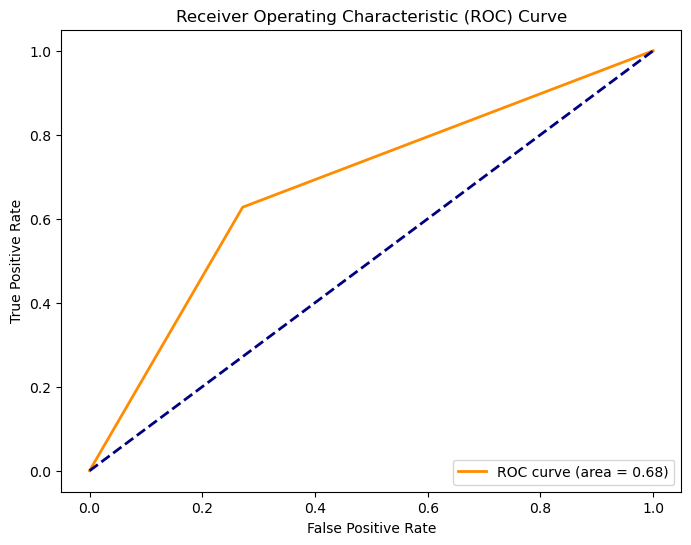

In [34]:
calculate_metrics_and_plot(confusion_true_RNN, confusion_pred_RNN)

In [39]:
#!pip install torch
#!pip install tabpfn
from tabpfn import TabPFNClassifier
import time
from sklearn.metrics import accuracy_score
import warnings
import gc
from sklearn.ensemble import RandomForestClassifier
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

def remove_models_from_memory():
    # Iterate over all objects in the global scope
    for obj_name in list(globals()):
        obj = globals()[obj_name]
        if isinstance(obj, torch.nn.Module):
            # If the object is a PyTorch model, delete it
            del globals()[obj_name]
warnings.filterwarnings("ignore", category=UserWarning)
X_new=train_data_rbp
labels=train_labels_s
success_arr = []
predictions = []
predictions_prob = []
for x,y in zip(X_new,labels):
    print(x.shape)
    print(y.shape)
    print(len(x))
    print(len(y))

for current in range(len(X_new)):
    remove_models_from_memory()
    print(f"Leave-One-Subject-Out: Testing on subject {current + 1}/{len(X_new)}")
    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=5)
    x_train = X_new
    y_train = labels
    x_test = (x_train.pop(current)).reshape(1,-1)
    x_train = (x_train)
    y_test = (y_train.pop(current))
    y_train = y_train
    classifier.fit(x_train, y_train)
    y_pred, p_pred = classifier.predict(x_test, return_winning_probability=True)
    #clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    
    # Fit the classifier to the training data]
    #clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    #y_pred = clf.predict(x_test)
    predictions.append(y_pred)
    predictions_prob.append(p_pred)
    
confusion_mtx = confusion_matrix(labels, predictions)

# Define class names
class_names = ["Control group(0)", "Alzheimer group(1)"]

# Calculate accuracy, sensitivity, specificity, precision, and F1-score
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

# Output metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("Specificity:", specificity)
print("F1-score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(labels, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


(74, 19, 25)
(74,)
74
74
(87, 19, 25)
(88,)
87
88
(87, 19, 25)
(87,)
87
87
(83, 19, 25)
(95,)
83
95
(76, 19, 25)
(74,)
76
74
(88, 19, 25)
(87,)
88
87
(80, 19, 25)
(87,)
80
87
(84, 19, 25)
(83,)
84
83
(84, 19, 25)
(76,)
84
76
(74, 19, 25)
(88,)
74
88
(80, 19, 25)
(80,)
80
80
(79, 19, 25)
(84,)
79
84
(77, 19, 25)
(84,)
77
84
(78, 19, 25)
(74,)
78
74
(97, 19, 25)
(80,)
97
80
(81, 19, 25)
(79,)
81
79
(95, 19, 25)
(77,)
95
77
(77, 19, 25)
(78,)
77
78
(73, 19, 25)
(97,)
73
97
(75, 19, 25)
(81,)
75
81
(78, 19, 25)
(95,)
78
95
(79, 19, 25)
(77,)
79
77
(88, 19, 25)
(73,)
88
73
(78, 19, 25)
(75,)
78
75
(78, 19, 25)
(78,)
78
78
(114, 19, 25)
(79,)
114
79
(92, 19, 25)
(88,)
92
88
(78, 19, 25)
(78,)
78
78
(60, 19, 25)
(78,)
60
78
(75, 19, 25)
(114,)
75
114
(69, 19, 25)
(92,)
69
92
(83, 19, 25)
(78,)
83
78
(81, 19, 25)
(60,)
81
60
(29, 19, 25)
(75,)
29
75
(81, 19, 25)
(69,)
81
69
(82, 19, 25)
(83,)
82
83
(91, 19, 25)
(81,)
91
81
(80, 19, 25)
(29,)
80
29
(95, 19, 25)
(81,)
95
81
(90, 19, 25)
(82,)
90

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (57,) + inhomogeneous part.